In [64]:
# modulos y librerias

import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import time
import collections

import plotly.graph_objects as go
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [65]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [66]:
catalog.layers

defaultdict(set,
            {'raw': {'hado_17',
              'hado_18',
              'hado_19',
              'hado_20',
              'hado_21',
              'hado_22'},
             'raw_preprocessing': {'hado_concat'},
             'raw_processing': {'hado_clean'},
             'intermediate_processing': {'hado_clean_na',
              'hado_replaced_words'},
             'final_processing': {'hado_cleaned'},
             'intermediate': {'hado_values'}})

In [67]:
df = catalog.load('hado_cleaned')

[08/03/23 15:23:21] INFO     Loading data from 'hado_cleaned' (CSVDataSet)...                   data_catalog.py:345

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   h_procedencia         4013 non-null   object
 1   s_procedencia         4013 non-null   object
 2   ap                    4013 non-null   object
 3   otros                 4013 non-null   object
 4   diagnostico           4013 non-null   object
 5   motivo_ing            4013 non-null   object
 6   paliativo_onc_noc     4013 non-null   object
 7   paliativo_no_onc_noc  4013 non-null   object
 8   fiebre                4013 non-null   object
 9   disnea                4013 non-null   object
 10  dolor                 4013 non-null   object
 11  delirium              4013 non-null   object
 12  otros_1               4013 non-null   object
 13  p_terminal            4013 non-null   object
 14  agonia                4013 non-null   object
 15  ps_ecog               4013 non-null   

In [69]:
df.head()

h_procedencia s_procedencia  ap otros                  diagnostico  \
0   gil casares          upal  no    no                   cancer orl   
1       clinico     oncologia  no    no              melanoma vulvar   
2       clinico           mir  no    no          cancer broncogenico   
3       clinico     digestivo  no    no            cirrosis hepatica   
4       clinico     urgencias  no    no  neplasia de mama estadio IV   

                  motivo_ing paliativo_onc_noc paliativo_no_onc_noc fiebre  \
0           control sintomas                si                   si     no   
1          mal control dolor                si                   no     no   
2          control evolutivo                si                   si     no   
3  administracion octreotido                no                   no     no   
4           control sintomas                si                   no     no   

  disnea dolor delirium otros_1 p_terminal agonia ps_ecog  barthel  gds_fast  \
0     no    si       no      no         si     no      40      300         0   
1     no    si       no      no         si     no      34        0         0   
2     si    no       no      no         no     no      34      400         0   
3     no    no       no      no         no     no      10      900         0   
4     si    si       no      no         si     no      40      300         0   

   eva_ing otros_2     otros_complicaciones  n_estancias  n_visitas sedacion  \
0        0      no   reingreso en urgencias           21         10       no   
1        0      no  met pulmonares y digest           24          8       no   
2        0      no                       no           14          6       no   
3        0      no                       no            1          1       no   
4       70      no                       no            2          1       no   

    motivo_alta        medico  year ast_anorx agudo_estable cronico_reag  \
0     reingreso        valdes  2017        si         vacio        vacio   
1        exitus   galego feal  2017        si         vacio        vacio   
2  fin cuidados  lopez renedo  2017        no         vacio        vacio   
3  fin cuidados  lopez renedo  2017        no         vacio        vacio   
4        exitus  lopez renedo  2017        no         vacio        vacio   

  trato_antibiotico transfusion paracentesis toracocentesis ayuntamiento  \
0             vacio       vacio        vacio          vacio  desconocido   
1             vacio       vacio        vacio          vacio  desconocido   
2             vacio       vacio        vacio          vacio  desconocido   
3             vacio       vacio        vacio          vacio  desconocido   
4             vacio       vacio        vacio          vacio  desconocido   

  fecha_alta  fe_iv  
0    unknown  vacio  
1    unknown  vacio  
2    unknown  vacio  
3    unknown  vacio  
4    unknown  vacio

# 1.Diagnostics Frecuency

In [70]:
diagnostic_counts = df['diagnostico'].value_counts()
print(diagnostic_counts)

ITU (infeccion del tracto urinario)    172
infeccion respiratoria                 145
infeccion urinaria                     112
insuficiencia cardiaca                  73
cancer de colon                         70
                                      ... 
sobreinfeccion placas calcinosis         1
cancer oral                              1
infeccion abdominal                      1
cancer urotelial alto grado              1
neoplasia pulmon                         1
Name: diagnostico, Length: 1519, dtype: int64


In [71]:
df['diagnostico'].value_counts(normalize=True, sort=True, ascending=False, dropna=False)

ITU (infeccion del tracto urinario)    0.042861
infeccion respiratoria                 0.036133
infeccion urinaria                     0.027909
insuficiencia cardiaca                 0.018191
cancer de colon                        0.017443
                                         ...   
sobreinfeccion placas calcinosis       0.000249
cancer oral                            0.000249
infeccion abdominal                    0.000249
cancer urotelial alto grado            0.000249
neoplasia pulmon                       0.000249
Name: diagnostico, Length: 1519, dtype: float64

# 2.Analysis of the most common diagnoses

In [72]:
top_diagnoses = diagnostic_counts.index[:5]  # Ajusta el número según tus necesidades
for diagnosis in top_diagnoses:
    print(diagnosis,"\n", df[df['diagnostico'] == diagnosis].groupby('motivo_alta').size().sort_values(ascending=False), "\n")

ITU (infeccion del tracto urinario) 
 motivo_alta
fin cuidados    156
exitus           15
reingreso         1
dtype: int64 

infeccion respiratoria 
 motivo_alta
fin cuidados                      120
exitus                             17
reingreso                           2
ingreso en upal                     1
ingreso oncologia                   1
reingreso en neumologia             1
reingreso en upal                   1
traslado a urgencias                1
traslado a urgencias por covid      1
dtype: int64 

infeccion urinaria 
 motivo_alta
fin cuidados            106
exitus                    5
traslado a urgencias      1
dtype: int64 

insuficiencia cardiaca 
 motivo_alta
fin cuidados               49
exitus                     15
reingreso                   3
traslado a urgencias        2
ingreso en mir              1
reingreso en upal           1
traslado a acv              1
traslado mir provincial     1
dtype: int64 

cancer de colon 
 motivo_alta
fin cuidados            33


In [73]:
top_diagnoses = diagnostic_counts.index[:5]  # Adjust the number according to your needs
for diagnosis in top_diagnoses:
    for col in df:
        if col != 'diagnostico':
            print(f"---Top diagnosticos--- \n{top_diagnoses}\n")
            print(df[df['diagnostico'] == diagnosis].groupby(col).size().sort_values(ascending=False), "\n")
        else:
            continue


---Top diagnosticos--- 
Index(['ITU (infeccion del tracto urinario)', 'infeccion respiratoria',
       'infeccion urinaria', 'insuficiencia cardiaca', 'cancer de colon'],
      dtype='object')

h_procedencia
clinico        98
no             51
conxo          14
gil casares     8
chuac           1
dtype: int64 

---Top diagnosticos--- 
Index(['ITU (infeccion del tracto urinario)', 'infeccion respiratoria',
       'infeccion urinaria', 'insuficiencia cardiaca', 'cancer de colon'],
      dtype='object')

s_procedencia
urgencias           54
no                  51
mir                 43
nefrologia           8
urologia             5
reumatologia         3
mir provincial       2
upal                 2
cardiologia          1
hematologia          1
medicina interna     1
oncologia            1
dtype: int64 

---Top diagnosticos--- 
Index(['ITU (infeccion del tracto urinario)', 'infeccion respiratoria',
       'infeccion urinaria', 'insuficiencia cardiaca', 'cancer de colon'],
      dtype='obje

# 3.Visualisation of diagnoses

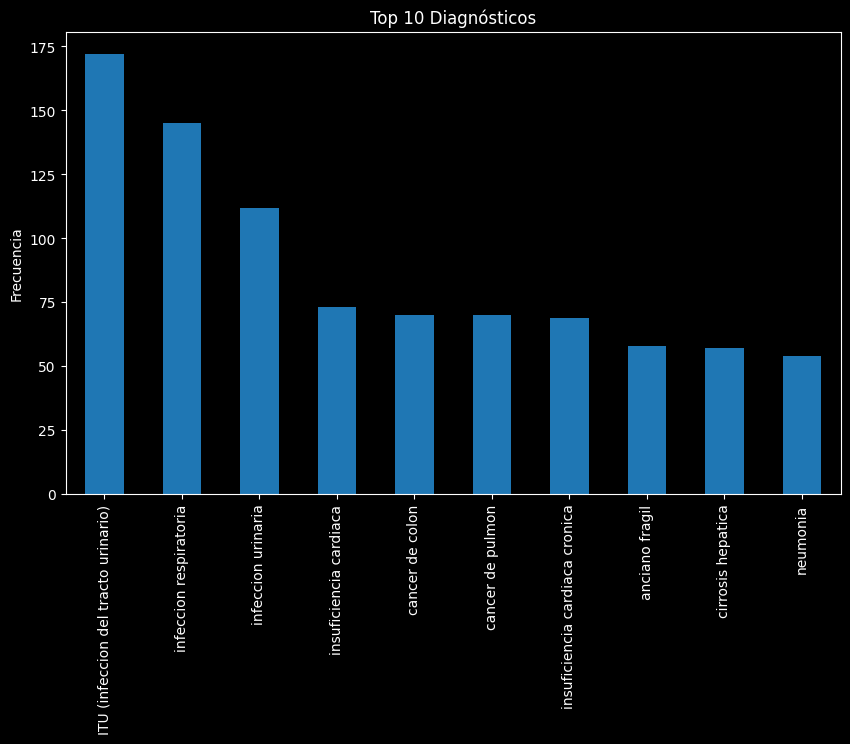

In [10]:
top_10_diagnostic_counts = diagnostic_counts[:10]  # Seleccionamos los 10 diagnósticos más comunes

fig, ax = plt.subplots(figsize=(10,6))
top_10_diagnostic_counts.plot(kind='bar',ax=ax, color='tab:blue')
ax.set_title('Top 10 Diagnósticos')
ax.set_ylabel('Frecuencia')
ax.tick_params(axis='x', rotation=90)
plt.show()


# 4.Diagnostic analysis by year

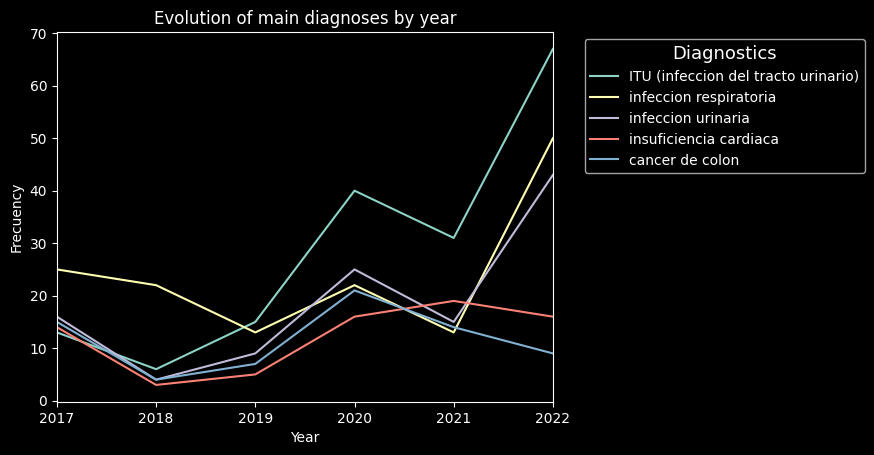

In [11]:
df['year'] = pd.to_datetime(df['year'], format="%Y")  # Convert the year to a date format
diagnosis_by_year = df.groupby(['year', 'diagnostico']).size().unstack('diagnostico')
diagnosis_by_year[top_diagnoses].plot(kind='line')
plt.title('Evolution of main diagnoses by year')
plt.xlabel('Year')
plt.ylabel('Frecuency')
plt.legend(title='Diagnostics', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 5.Pandas Profiling

In [12]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

[08/02/23 19:31:51] WARNING  C:\Users\Pablo                                                         warnings.py:109
                             Villar\AppData\Local\Temp\ipykernel_12856\1527940821.py:1:                            
                             DeprecationWarning: `import pandas_profiling` is going to be                          
                             deprecated by April 1st. Please use `import ydata_profiling` instead.                 
                               from pandas_profiling import ProfileReport                                          
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas_profiling\pro                
                             file_report.py:464: DeprecationWarning: Importing display from                        
                             IPython.core.display is deprecated since IPython 7.14, please import                  
                             from IPython display                                                                  
                               from IPython.core.display import display                                            
                                                                                                                   

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

[08/02/23 19:31:54] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas_profiling\vis                
                             ualisation\context.py:85: MatplotlibDeprecationWarning: mplDeprecation                
                             was deprecated in Matplotlib 3.6 and will be removed two minor                        
                             releases later. Use matplotlib.MatplotlibDeprecationWarning instead.                  
                               warnings.filterwarnings("ignore",                                                   
                             category=matplotlib.cbook.mplDeprecation)                                             
                                                                                                                   

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

[08/02/23 19:32:00] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas_profiling\rep                
                             ort\presentation\flavours\widget\correlation_table.py:1:                              
                             DeprecationWarning: Importing display from IPython.core.display is                    
                             deprecated since IPython 7.14, please import from IPython display                     
                               from IPython.core.display import display                                            
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas_profiling\rep                
                             ort\presentation\flavours\widget\duplicate.py:1: DeprecationWarning:                  
                             Importing display from IPython.core.display is deprecated since                       
                             IPython 7.14, please import from IPython display                                      
                               from IPython.core.display import display                                            
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas_profiling\rep                
                             ort\presentation\flavours\widget\sample.py:1: DeprecationWarning:                     
                             Importing display from IPython.core.display is deprecated since                       
                             IPython 7.14, please import from IPython display                                      
                               from IPython.core.display import display                                            
                                                                                                                   

In [13]:
profile.to_file("pandas_profile_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 6.DASH

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# Inicializando la aplicación
app = dash.Dash(__name__)

# Creando el layout de la aplicación
app.layout = html.Div([
    html.H1("Análisis de Diagnósticos"),
    dcc.Dropdown(
        id='diagnostico',
        options=[{'label': i, 'value': i} for i in df['diagnostico'].unique()],
        value='ITU (infeccion del tracto urinario)'
    ),
    dcc.Graph(id='graph'),
])

# Función callback para actualizar el gráfico basado en el diagnóstico seleccionado
@app.callback(
    Output('graph', 'figure'),
    [Input('diagnostico', 'value')]
)
def update_figure(selected_diagnosis):
    filtered_df = df[df.diagnostico == selected_diagnosis]
    fig = px.histogram(filtered_df, x="s_procedencia", 
                       title=f"Frecuencia de procedencia para {selected_diagnosis}")

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


[07/20/23 18:28:08] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\dash\_jupyter.py:31:                
                             DeprecationWarning: The `ipykernel.comm.Comm` class has been                          
                             deprecated. Please use the `comm` module instead.For creating comms,                  
                             use the function `from comm import create_comm`.                                      
                               _dash_comm = Comm(target_name="dash")                                               
                                                                                                                   

                    WARNING  C:\Users\Pablo                                                         warnings.py:109
                             Villar\AppData\Local\Temp\ipykernel_10236\4093923071.py:2:                            
                             UserWarning:                                                                          
                             The dash_core_components package is deprecated. Please replace                        
                             `import dash_core_components as dcc` with `from dash import dcc`                      
                               import dash_core_components as dcc                                                  
                                                                                                                   

                    WARNING  C:\Users\Pablo                                                         warnings.py:109
                             Villar\AppData\Local\Temp\ipykernel_10236\4093923071.py:3:                            
                             UserWarning:                                                                          
                             The dash_html_components package is deprecated. Please replace                        
                             `import dash_html_components as html` with `from dash import html`                    
                               import dash_html_components as html                                                 
                                                                                                                   

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# Inicializando la aplicación
app = dash.Dash(__name__)

# Creando el layout de la aplicación
app.layout = html.Div([
    html.H1("Análisis de Diagnósticos"),
    dcc.Dropdown(
        id='diagnostico',
        options=[{'label': i, 'value': i} for i in df['diagnostico'].unique()],
        value='ITU (infeccion del tracto urinario)'
    ),
    dcc.Dropdown(
        id='column',
        options=[{'label': i, 'value': i} for i in df.columns],
        value='s_procedencia'
    ),
    dcc.Graph(id='graph'),
])

# Función callback para actualizar el gráfico basado en el diagnóstico y columna seleccionada
@app.callback(
    Output('graph', 'figure'),
    [Input('diagnostico', 'value'), Input('column', 'value')]
)
def update_figure(selected_diagnosis, selected_column):
    filtered_df = df[df.diagnostico == selected_diagnosis]
    fig = px.histogram(filtered_df, x=selected_column, 
                       title=f"Frecuencia de {selected_column} para {selected_diagnosis}")

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# Inicializando la aplicación
app = dash.Dash(__name__)

# Estilo personalizado
colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

# Creando el layout de la aplicación
app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Análisis de Diagnósticos',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),
    html.Div(children='Seleccione un diagnóstico y una columna para visualizar:', style={
        'textAlign': 'center',
        'color': colors['text']
    }),
    dcc.Dropdown(
        id='diagnostico',
        options=[{'label': i, 'value': i} for i in df['diagnostico'].unique()],
        value='ITU (infeccion del tracto urinario)',
        style={
            'width': '50%',
            'padding-left': '25%',
            'padding-right': '25%',
            'color': colors['text']
        }
    ),
    dcc.Dropdown(
        id='column',
        options=[{'label': i, 'value': i} for i in df.columns],
        value='s_procedencia',
        style={
            'width': '50%',
            'padding-left': '25%',
            'padding-right': '25%',
            'color': colors['text']
        }
    ),
    dcc.Graph(id='graph'),
])

# Función callback para actualizar el gráfico basado en el diagnóstico y columna seleccionada
@app.callback(
    Output('graph', 'figure'),
    [Input('diagnostico', 'value'), Input('column', 'value')]
)
def update_figure(selected_diagnosis, selected_column):
    filtered_df = df[df.diagnostico == selected_diagnosis]
    # Ordenando los valores del histograma y tomando solo los 10 más comunes
    filtered_df = filtered_df[selected_column].value_counts().sort_values(ascending=False).reset_index()
    fig = px.histogram(filtered_df, x='index', y=selected_column,
                       title=f"Frecuencia de {selected_column} para {selected_diagnosis}")
    fig.update_layout(
        plot_bgcolor=colors['background'],
        paper_bgcolor=colors['background'],
        font_color=colors['text']
    )
    # Actualizando las etiquetas del eje X
    fig.update_xaxes(title=selected_column)

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas\core\indexes\base.py:3802, in Index.get_loc(
    self=Index(['h_procedencia', 's_procedencia', 'ap', '...o', 'fecha_alta', 'fe_iv'],
      dtype='object'),
    key=None,
    method=None,
    tolerance=None
)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
        casted_key = None
        self = Index(['h_procedencia', 's_procedencia', 'ap', 'otros', 'diagnostico',
       'motivo_ing', 'paliativo_onc_noc', 'paliativo_no_onc_noc', 'fiebre',
       'disnea', 'dolor', 'delirium', 'otros_1', 'p_terminal', 'agonia',
       'ps_ecog', 'barthel', 'gds_fast', 'eva_ing', 'otros_2',
       'otros_complicaciones', 'n_estancias', 'n_visitas', 'sedacion',
       'motivo_alta', 'medico', 'year', 'ast_anorx', 'agud

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# Inicializando la aplicación
app = dash.Dash(__name__)

# Estilo personalizado
colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

# Creando el layout de la aplicación
app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Análisis de Diagnósticos',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),
    html.Div(children='Seleccione un diagnóstico y una columna para visualizar:', style={
        'textAlign': 'center',
        'color': colors['text']
    }),
    dcc.Dropdown(
        id='diagnostico',
        options=[{'label': i, 'value': i} for i in df['diagnostico'].unique()],
        value='ITU (infeccion del tracto urinario)',
        style={
            'width': '50%',
            'padding-left': '25%',
            'padding-right': '25%',
            'color': colors['text']
        }
    ),
    dcc.Dropdown(
        id='column',
        options=[{'label': i, 'value': i} for i in df.columns],
        value='s_procedencia',
        style={
            'width': '50%',
            'padding-left': '25%',
            'padding-right': '25%',
            'color': colors['text']
        }
    ),
    dcc.Graph(id='graph'),
    html.Button('Reset', id='reset_button')
])

# Función callback para actualizar el gráfico basado en el diagnóstico y columna seleccionada
@app.callback(
    Output('graph', 'figure'),
    [Input('diagnostico', 'value'), Input('column', 'value'), Input('reset_button', 'n_clicks')]
)
def update_figure(selected_diagnosis, selected_column, n_clicks):
    if n_clicks is None:
        filtered_df = df[df.diagnostico == selected_diagnosis]
        filtered_df = filtered_df[selected_column].value_counts().nlargest(10).sort_values().reset_index()
        fig = px.bar(filtered_df, x=selected_column, y='index', orientation='h',
                     title=f"Frecuencia de {selected_column} para {selected_diagnosis}")
        fig.update_layout(
            plot_bgcolor=colors['background'],
            paper_bgcolor=colors['background'],
            font_color=colors['text']
        )
        # Actualizando las etiquetas del eje X
        fig.update_xaxes(title=selected_column)
        fig.update_yaxes(title=selected_diagnosis)

        return fig
    else:
        raise dash.exceptions.PreventUpdate


if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data Science\TFM\nuevo_entorno_kedro\lib\site-packages\pandas\core\indexes\base.py:3802, in Index.get_loc(
    self=Index(['h_procedencia', 's_procedencia', 'ap', '...o', 'fecha_alta', 'fe_iv'],
      dtype='object'),
    key=None,
    method=None,
    tolerance=None
)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
        casted_key = None
        self = Index(['h_procedencia', 's_procedencia', 'ap', 'otros', 'diagnostico',
       'motivo_ing', 'paliativo_onc_noc', 'paliativo_no_onc_noc', 'fiebre',
       'disnea', 'dolor', 'delirium', 'otros_1', 'p_terminal', 'agonia',
       'ps_ecog', 'barthel', 'gds_fast', 'eva_ing', 'otros_2',
       'otros_complicaciones', 'n_estancias', 'n_visitas', 'sedacion',
       'motivo_alta', 'medico', 'year', 'ast_anorx', 'agud

Una vez se haya realizado la limpieza y preprocesamiento realizamos los siguientes pasos:

# 1.Vectorización de texto

La vectorización de texto es el proceso de convertir palabras en vectores numéricos que pueden ser entendidos y procesados por un algoritmo de machine learning. Existen diferentes técnicas para hacer esto, entre las que se incluyen Bag of Words, TF-IDF, y Word2Vec.

>Word2Vec es un método que utiliza redes neuronales para aprender representaciones vectoriales de palabras a partir de un corpus de texto. Este método tiene la ventaja de que puede capturar el significado semántico de las palabras.

Tenemos que convertir los diagnosticos en una lista de listas haciendo un split de la variable 
```python
diagnosticos = df['diagnosticos'].unique()`
```
Utilizaremos para los vectores
1. **Máximo**: En lugar de tomar el promedio de los vectores de palabras, puedo tomar el máximo de cada componente de los vectores de palabras. Este enfoque podría capturar la "palabra más importante" en cada dimensión del espacio vectorial.

2. **Suma**:Podría sumar los vectores de las palabras, lo que daría más peso a los diagnósticos con más palabras.

3. **Promedio**:Promediando los vectores de todas las palabras en cada diagnóstico.

4. **Concatenación**:si el tamaño de los vectores es pequeño, podría considerarse concatenar los vectores de las palabras en lugar de promediarlos. Esto resultaría en vectores de diagnóstico más grandes, pero también podría capturar más información.

## 1.1.Stopwords

In [ ]:
df\
.isna()\
.sum()

h_procedencia              0
s_procedencia              0
ap                         0
otros                      0
diagnostico                0
motivo_ing                 0
paliativo_onc_noc          0
paliativo_no_onc_noc       0
fiebre                     0
disnea                     0
dolor                      0
delirium                   0
otros_1                    0
p_terminal                 0
agonia                     0
ps_ecog                    1
barthel                    1
gds_fast                   0
eva_ing                 2465
otros_2                    0
otros_complicaciones       0
n_estancias                0
n_visitas                  0
sedacion                   0
motivo_alta                0
medico                     0
year                       0
ast_anorx                  0
agudo_estable              0
cronico_reag               0
trato_antibiotico          0
transfusion                0
paracentesis               0
toracocentesis             0
ayuntamiento  

In [ ]:
# Cargamos las stopwords
from nltk.corpus import stopwords

# Descargar las stopwords de NLTK
nltk.download('stopwords')

# Obtener las stopwords en español
stopwords_es = stopwords.words('spanish')

# Aplicar la eliminación de stopwords a las columnas deseadas
columns_to_clean = ['motivo_ing', 'motivo_alta', 'diagnostico',]

for column in columns_to_clean:
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_es]))


[nltk_data] Downloading package stopwords to C:\Users\Pablo
[nltk_data]     Villar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(stopwords_es)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

## 1.2.Split for list of lists

In [ ]:
# Hacemos una lista de listas para poder pasar los textos a vectores

diagnosticos = df['diagnostico'].unique()

diagnosticos_split = [diagnostico.split() for diagnostico in diagnosticos]

# Filtro diagnosticos vacíos si existen... 
diagnosticos_split = [diagnostico for diagnostico in diagnosticos_split if diagnostico]

# 2.Word2Vec

Word2Vec es una técnica específica que se utiliza para el aprendizaje automático de representaciones de palabras. En esencia, convierte palabras en vectores de números de tal manera que las palabras con significados similares terminan con vectores similares. Esto permite que las operaciones matemáticas se realicen en palabras, lo que puede ser muy útil para muchas tareas de NLP.



In [ ]:
from gensim.models import Word2Vec

# Asumiendo que los diagnósticos ya están preprocesados y almacenados en una lista de listas,
# donde cada lista interna contiene las palabras de un diagnóstico.
# Por ejemplo: [["neoplasia", "pancreas"], ["adenocarcinoma", "de", "pulmón"], ...]

# Entrenamos el modelo Word2Vec
model = Word2Vec(diagnosticos_split, min_count=5, vector_size=50)

# Ahora podemos obtener el vector de una palabra en particular
vector = model.wv['cancer']

# O incluso obtener la palabra más similar a 'neoplasia'
similar = model.wv.most_similar('cancer')


### En el código anterior, min_count es el número mínimo de veces que una palabra debe aparecer en el corpus para ser incluida en el modelo, y vector_size es la dimensión de los vectores de palabra.

In [ ]:
similar

[('secuelas', 0.5250375270843506),
 ('sien', 0.45964503288269043),
 ('llc', 0.40486276149749756),
 ('asintomatica', 0.3927736282348633),
 ('varicosaobesidad', 0.37621062994003296),
 ('trombopenia', 0.3689652979373932),
 ('probable', 0.3682882785797119),
 ('paciente', 0.35990747809410095),
 ('demencia', 0.35750800371170044),
 ('patologica', 0.35407063364982605)]

In [ ]:
vector

array([-0.00059652,  0.00052158,  0.01040444,  0.01960699, -0.01930834,
       -0.01782835,  0.01624978,  0.02377817, -0.01329277, -0.00915849,
        0.0150449 , -0.00675792, -0.00875667,  0.01406383, -0.01399724,
       -0.00316409,  0.00747885,  0.00245794, -0.02084139, -0.02306509,
        0.0167302 ,  0.01300388,  0.01950894, -0.00136382,  0.01689705,
       -0.00717178, -0.00369646,  0.01144311, -0.01979169, -0.00762602,
       -0.0137384 , -0.00280863,  0.01857205, -0.0136458 , -0.00803991,
       -0.00228907,  0.01822545, -0.01289072,  0.00048408, -0.01278737,
       -0.01683586,  0.01039587, -0.01972936, -0.00783317,  0.00651448,
        0.00119866, -0.01783084,  0.01660989,  0.0131074 ,  0.0200562 ],
      dtype=float32)

```python
model = Word2Vec(diagnosticos_split, min_count=1, vector_size=50)
```
En `model` se está entrenando un modelo **Word2Vec** con los diagnósticos.

* La opción **min_count=1** significa que las palabras que aparecen al menos una vez en los diagnósticos serán consideradas por el modelo.

* **vector_size=50** define la dimensionalidad de los vectores de palabras generados por el modelo.
```python
model.wv['cancer']
```
* Devuelve el vector de la palabra `cancer`. Este vector es un arreglo de 50 números ***(porque se ha definido vector_size=50)*** que representa el significado de `cancer` según lo aprendido por el modelo de los diagnósticos.
```python
model.wv.most_similar('cancer')
```
* Devuelve las palabras más similares a `cancer` según lo aprendido por el modelo de los diagnósticos. La similitud se mide en términos de la similitud del coseno entre los vectores de palabras.

>**El modelo Word2Vec** necesita una gran cantidad de datos para aprender representaciones de palabras significativas. Si solo existe un pequeño número de diagnósticos, los vectores de palabras generados por el modelo podrían no ser muy significativos. En este caso, se puede considerar el uso de vectores de palabras pre-entrenados, como los disponibles en bibliotecas como spaCy o gensim.

## 2.1.Gensim

Gensim es una biblioteca de Python muy popular para el modelado de temas y el procesamiento del lenguaje natural (NLP). Proporciona implementaciones eficientes y escalables de varios algoritmos de NLP, como Word2Vec, FastText, Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA) y otros.

Gensim es una opción popular para usar Word2Vec por varias razones:

1. **Eficiencia**: Gensim está diseñado para ser eficiente y para manejar grandes conjuntos de datos. Utiliza técnicas como la transmisión de datos y la segmentación de memoria para mantener una huella de memoria baja.

2. **Facilidad de uso**: Gensim proporciona una interfaz simple y directa para el uso de algoritmos de NLP complejos como Word2Vec.

3. **Flexibilidad**: Gensim permite un control detallado sobre los parámetros de los modelos, lo que puede ser útil para ajustar el rendimiento del modelo para tareas específicas.

4. **Comunidad de apoyo**: Gensim es una biblioteca muy utilizada con una gran comunidad de usuarios y desarrolladores. Esto significa que hay una gran cantidad de documentación, tutoriales y soporte disponible.

En cuanto a por qué Word2Vec y Gensim son buenas elecciones para el análisis de diagnósticos médicos, hay varias razones. Primero, los diagnósticos médicos a menudo contienen términos y frases muy específicos, y Word2Vec puede ser útil para capturar las similitudes semánticas entre estos términos. Además, Gensim es una opción práctica porque permite un manejo eficiente de grandes conjuntos de datos, que a menudo se encuentran en aplicaciones médicas. Por último, la capacidad de Gensim para ajustar detalladamente los parámetros del modelo puede ser útil para afinar el rendimiento del modelo en el análisis de diagnósticos médicos.


## 2.2.Enfoque TF-IDF

No todos los diagnósticos tendrán el mismo número de palabras, y algunos diagnósticos pueden tener palabras que son más importantes que otras para determinar el significado del diagnóstico. En estos casos, tomar el promedio de los vectores de palabras puede no ser la mejor representación.

Una opción es usar un enfoque más sofisticado como TF-IDF (Term Frequency-Inverse Document Frequency) para dar más peso a las palabras que son más importantes en un diagnóstico y menos peso a las palabras que son comunes en muchos diagnósticos.

> Pero, en muchos casos, palabras comunes como "cancer" o "infeccion" son de hecho muy importantes para el diagnóstico, y el enfoque TF-IDF puede darles menos peso porque son comunes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import time

start_time = time.time()

# Convertimos los diagnósticos a cadenas de texto para usar con TfidfVectorizer
diagnosticos_str = [' '.join(diagnostico) for diagnostico in diagnosticos_split]

# Entrenamos el modelo Word2Vec
model = Word2Vec(diagnosticos_split, min_count=10, vector_size=50)

# Creamos un diccionario para mapear cada palabra a su vector Word2Vec
word_to_vec = {word: model.wv[word] for word in model.wv.key_to_index.keys()}

# Crea un vectorizador TF-IDF, limitando el vocabulario a las palabras que están en el modelo Word2Vec
vectorizer = TfidfVectorizer(vocabulary=model.wv.key_to_index)

# Calcula los vectores TF-IDF para los diagnósticos
tfidf = vectorizer.fit_transform(diagnosticos_str)

# Ahora podemos obtener el vector TF-IDF para cada diagnóstico
diagnosticos_vec = []
for i in range(tfidf.shape[0]):
    tfidf_diag = tfidf.getrow(i)
    diag_vec = np.mean([word_to_vec[word] * tfidf_diag[0, vectorizer.vocabulary_[word]] 
                        for word in diagnosticos_split[i] if word in word_to_vec], axis=0)
    diagnosticos_vec.append(diag_vec)

end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

[07/18/23 17:47:19] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\feature_extr                
                             action\text.py:1380: UserWarning: Upper case characters found in                      
                             vocabulary while 'lowercase' is True. These entries will not be                       
                             matched with any documents                                                            
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\numpy\core\fromnumer                
                             ic.py:3432: RuntimeWarning: Mean of empty slice.                                      
                               return _methods._mean(a, axis=axis, dtype=dtype,                                    
                                                                                                                   

                    WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\numpy\core\_methods.                
                             py:190: RuntimeWarning: invalid value encountered in double_scalars                   
                               ret = ret.dtype.type(ret / rcount)                                                  
                                                                                                                   

Tiempo de ejecución: 0.11478281021118164 segundos


In [ ]:
diagnosticos_vec[0]
# cada vector representa un diagnóstico en el conjunto de datos, por lo que cada número 
# en el vector corresponde a un peso TF-IDF para una palabra específica en ese diagnóstico.

array([-0.00102046,  0.00018882,  0.00996705,  0.0185625 , -0.0189649 ,
       -0.0148815 ,  0.01449917,  0.01942952, -0.01161842, -0.00806891,
        0.01469342, -0.00453226, -0.00717685,  0.01428259, -0.01026376,
       -0.00222402,  0.00643211,  0.00342221, -0.01825942, -0.01990509,
        0.01576431,  0.01085808,  0.01568508,  0.00126326,  0.01361326,
       -0.00692855, -0.00204157,  0.01303242, -0.01540585, -0.00802424,
       -0.01480373, -0.0031083 ,  0.01897023, -0.01479447, -0.00507291,
       -0.00383662,  0.0182998 , -0.01224265,  0.0002921 , -0.00902227,
       -0.01867805,  0.00997905, -0.01698893, -0.00943014,  0.00184899,
       -0.00041638, -0.01515919,  0.01747209,  0.01068364,  0.01848563],
      dtype=float32)

# 3.EDA Vectores 

1. **Calcular y graficar la longitud de los vectores**: La longitud (o norma) de un vector puede ser una característica interesante a explorar. Puede calcularse la longitud de un vector usando la función `np.linalg.norm`

2. **Visualizar los vectores con PCA**: Puede usarse el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de los vectores a 2 o 3 dimensiones, y luego visualizarlos en un gráfico de dispersión.

3. Otros...

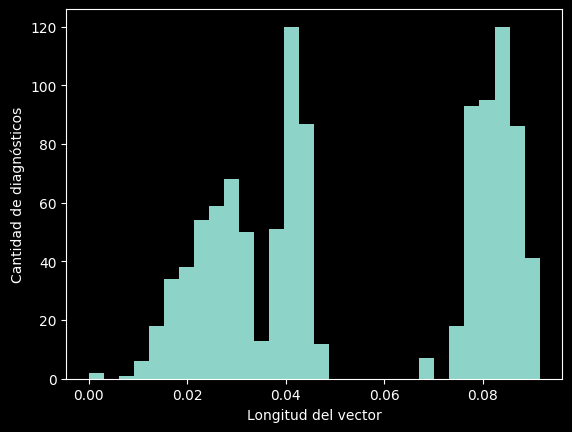

In [ ]:
# Calcular y graficar la longitud de los vectores

import matplotlib.pyplot as plt

# Calcula la longitud de cada vector
vector_lengths = [np.linalg.norm(vec) for vec in diagnosticos_vec]

# Grafica un histograma de las longitudes
plt.hist(vector_lengths, bins=30)
plt.xlabel('Longitud del vector')
plt.ylabel('Cantidad de diagnósticos')
plt.show();

In [ ]:
# Visualizar los vectores con PCA

from sklearn.decomposition import PCA

# Reduce la dimensionalidad a 2
pca = PCA(n_components=2)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Grafica los vectores en 2D
plt.scatter(diagnosticos_pca[:, 0], diagnosticos_pca[:, 1])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 # Reduce la dimensionalidad a 2                                                             │
│    6 pca = PCA(n_components=2)                                                                   │
│ ❱  7 diagnosticos_pca = pca.fit_transform(diagnosticos_vec)                                      │
│    8                                                                                             │
│    9 # Grafica los vectores en 2D                                                                │
│   10 plt.scatter(diagnosticos_pca[:, 0], diagnosticos_pca[:, 1])                                 │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\utils\_set_output.py:140 in wrapped    │
│                                                                                                  │
│   137 │                                                                                          │
│   138 │   @wraps(f)                                                                              │
│   139 │   def wrapped(self, X, *args, **kwargs):                                                 │
│ ❱ 140 │   │   data_to_wrap = f(self, X, *args, **kwargs)                                         │
│   141 │   │   if isinstance(data_to_wrap, tuple):                                                │
│   142 │   │   │   # only wrap the first output for cross decomposition                           │
│   143 │   │   │   return (                                                                       │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\decomposition\_pca.py:462 in           │
│ fit_transform                                                                                    │
│                                                                                                  │
│   459 │   │   """                                                                                │
│   460 │   │   self._validate_params()                                                            │
│   461 │   │                                                                                      │
│ ❱ 462 │   │   U, S, Vt = self._fit(X)                                                            │
│   463 │   │   U = U[:, : self.n_components_]                                                     │
│   464 │   │                                                                                      │
│   465 │   │   if self.whiten:                                                                    │
│                                                                                                  │
│ c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data                                      │
│ Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\decomposition\_pca.py:485 in _fit      │
│                                                                                                  │
│   482 │   │   │   │   "TruncatedSVD for a possible alternative."                                 │
│   483 │   │   │   )                                                                              │
│   484 │   │                                                

# Error
Este error se produce cuando se está intentando aplicar PCA a una lista de vectores, pero algunos de estos vectores no son de la misma longitud o son `None`. El error puede deberse a que algunas de las palabras en los diagnósticos no están en el modelo Word2Vec, por lo que no se creó ningún vector para ellas.

>Para solucionar este problema, puede hacerse una comprobación adicional al calcular los vectores de los diagnósticos. Si el vector para un diagnóstico es `None` o tiene longitud cero, puede reemplazarse por un vector de ceros.

````python
diagnosticos_vec = []
for i in range(tfidf.shape[0]):
    tfidf_diag = tfidf.getrow(i)
    words_vecs = [word_to_vec[word] * tfidf_diag[0, vectorizer.vocabulary_[word]] 
                  for word in diagnosticos_split[i] if word in word_to_vec]
    if words_vecs:
        diag_vec = np.mean(words_vecs, axis=0)
    else:
        diag_vec = np.zeros(model.vector_size)  # reemplaza vectores vacíos por vectores de ceros
    diagnosticos_vec.append(diag_vec)
````

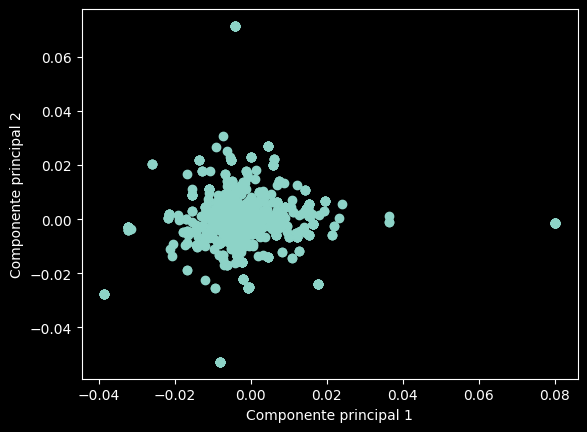

In [ ]:
# Visualizar los vectores con PCA

from sklearn.decomposition import PCA

# Vectores con la misma longitud
diagnosticos_vec = []
for i in range(tfidf.shape[0]):
    tfidf_diag = tfidf.getrow(i)
    words_vecs = [word_to_vec[word] * tfidf_diag[0, vectorizer.vocabulary_[word]] 
                  for word in diagnosticos_split[i] if word in word_to_vec]
    if words_vecs:
        diag_vec = np.mean(words_vecs, axis=0)
    else:
        diag_vec = np.zeros(model.vector_size)  # reemplaza vectores vacíos por vectores de ceros
    diagnosticos_vec.append(diag_vec)
    
# Reduce la dimensionalidad a 2
pca = PCA(n_components=2)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Grafica los vectores en 2D
plt.scatter(diagnosticos_pca[:, 0], diagnosticos_pca[:, 1])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Reduce la dimensionalidad a 3
pca = PCA(n_components=3)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Crea el gráfico de dispersión 3D
fig = go.Figure(data=[go.Scatter3d(
    x=diagnosticos_pca[:, 0],
    y=diagnosticos_pca[:, 1],
    z=diagnosticos_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color='blue',                # color de los puntos
        opacity=0.8
    )
)])

# Actualiza los ejes del gráfico
fig.update_layout(
    scene = dict(
        xaxis_title='1',
        yaxis_title='2',
        zaxis_title='3'
    )
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Reduce la dimensionalidad a 3
pca = PCA(n_components=3)
diagnosticos_pca = pca.fit_transform(diagnosticos_vec)

# Crea el gráfico de dispersión 3D
fig = go.Figure(data=[go.Scatter3d(
    x=diagnosticos_pca[:, 0],
    y=diagnosticos_pca[:, 1],
    z=diagnosticos_pca[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=diagnosticos_pca[:, 2],   # utiliza la tercera componente para el color
        colorscale='Viridis',            # elige una escala de colores
        opacity=0.8
    )
)])

# Actualiza los ejes del gráfico
fig.update_layout(
    scene = dict(
        xaxis_title='Componente principal 1',
        yaxis_title='Componente principal 2',
        zaxis_title='Componente principal 3',
        aspectmode='cube'                # hace que los ejes tengan la misma escala
    ),
    margin=dict(l=0, r=0, b=0, t=0),    # elimina los márgenes alrededor del gráfico
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))   # ajusta la posición inicial de la cámara
)

fig.show()

# la opción aspectmode='cube' es para hacer que los ejes tengan la misma escala,
# lo que puede hacer que la visualización sea más fácil de interpretar.


# 4.Calculo los Vectores

## 4.1.Máximo (toma el valor máximo de cada dimensión a través de todas las palabras en el diagnóstico)


In [ ]:
import numpy as np

diagnosticos_vec_max = [np.max([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]


In [ ]:
from sklearn.cluster import KMeans

# Entonces podemos entrenar un modelo KMeans en estos vectores.
kmeans = KMeans(n_clusters=3)  # Ajusta este número a la cantidad de grupos que creas adecuada
kmeans.fit(diagnosticos_vec_max)

# Ahora podemos obtener las etiquetas de los grupos para cada diagnóstico
labels = kmeans.labels_

[07/18/23 17:47:20] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning:                                                            
                                                                                                                   
                             The default value of `n_init` will change from 10 to 'auto' in 1.4.                   
                             Set the value of `n_init` explicitly to suppress the warning                          
                                                                                                                   
                                                                                                                   

In [ ]:
labels

array([1, 0, 1, ..., 0, 0, 0])

## 4.2.Suma (suma los vectores de todas las palabras en el diagnóstico)

In [ ]:
diagnosticos_vec_sum = [np.sum([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]

## 4.3.Promedio (promediando los vectores de todas las palabras en cada diagnóstico)

In [ ]:
diagnosticos_vec_mean = [np.mean([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]

## 4.4.Concatenación (concatena los vectores de todas las palabras en el diagnóstico)

Este método requerirá que todas las listas de diagnósticos tengan la misma longitud (es decir, el mismo número de palabras). Si no es así, tendrás que rellenar las listas más cortas con algún valor (como un vector de ceros).

> Este último método puede resultar en vectores muy largos si los diagnósticos contienen muchas palabras, lo que puede hacer que los modelos de aprendizaje automático sean más difíciles de entrenar.

In [ ]:
from keras_preprocessing.sequence import pad_sequences

# Asumimos que 'max_len' es la longitud del diagnóstico más largo en 'diagnosticos_split'
max_len = max([len(diagnostico) for diagnostico in diagnosticos_split])

diagnosticos_pad = pad_sequences(diagnosticos_split, maxlen=max_len, dtype='object', padding='post')
'''pad_sequences se utiliza para garantizar que todas las secuencias (en este caso, listas de vectores de palabras) 
tengan la misma longitud añadiendo "relleno" según sea necesario. Este relleno se hace con vectores de ceros, 
que son de tipo float32, para que coincidan con el tipo de datos de los vectores de palabras existentes.'''

diagnosticos_vec_concat = [np.concatenate([model.wv[word] if word in model.wv.key_to_index else np.zeros(model.vector_size) for word in diagnostico]) for diagnostico in diagnosticos_pad]

In [ ]:
diagnosticos_vec_concat

[array([-0.00102046,  0.00018882,  0.00996705, ...,  0.        ,
         0.        ,  0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00102046,  0.00018882,  0.00996705, ...,  0.        ,
         0.        ,  0.        ]),
 array([0.01483201, 0.02010111, 0.01760369, ..., 0.        , 0.        ,
        0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00511572,  0.00644306, -0.00063821, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00499519, -0.01178145,  0.01496821, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.01881796, -0.0099284 , -0.0195568 , ...,  0.        ,
         0.        ,  0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00102046,  0.00018882,  0.00996705, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00102046,  0.00018882,  0.00996705, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.00022073,  0.00031232, -0.00065837, ...,  0.        ,
         0.     

>Ahora que tenemos los vectores de diagnóstico (ya sea máximo, suma, promedio o concatenación), pueden usarse como entrada para un algoritmo de aprendizaje automático o análisis de datos. Por ejemplo, estos vectores pueden alimentar a un algoritmo de clustering para agrupar diagnósticos similares, o a un algoritmo de clasificación para predecir alguna etiqueta basada en el texto del diagnóstico.

# Funciones

> Cuando tenemos un modelo Word2Vec model y una lista de diagnósticos divididos en palabras data_split podemos realizar estas funciones

Estas funciones realizan los siguientes pasos:
<hr>

* **create_vectors**: Crea vectores para los diagnósticos utilizando el método especificado (máximo, suma, media).

* **cluster_diagnosticos**: Aplica el algoritmo KMeans a los vectores de los diagnósticos.

* **create_clusters**: Crea un diccionario donde las llaves son las etiquetas de los clusters y los valores son las listas de diagnósticos que pertenecen a cada cluster.

* **print_clusters**: Imprime los diagnósticos en cada cluster.

* **print_top_words**: Imprime las palabras más comunes en cada cluster.
<hr>

* Código:
````python
import numpy as np
from sklearn.cluster import KMeans
import collections

def create_vectors(model, data_split, method='mean'):
    if method == 'max':
        data_vec = [np.max([model.wv[word] for word in data_item], axis=0) 
                            if data_item else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'sum':
        data_vec = [np.sum([model.wv[word] for word in text if word in model.wv.vocab], axis=0) 
                    for text in data_split]
        
    elif method == 'mean':
        data_vec = [np.mean([model.wv[word] for word in data_item], axis=0) 
                            if data_item else np.zeros(model.vector_size) 
                            for data_item in data_split]
    return data_vec

def cluster_data(data_vec, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_vec)
    labels = kmeans.labels_
    return labels

def create_clusters(data_split, labels, n_clusters=5):
    clusters = {i: [] for i in range(n_clusters)}
    for data_item, label in zip(data_split, labels):
        clusters[label].append(' '.join(data_item))
    return clusters

def print_clusters(clusters):
    for label, data_items in clusters.items():
        print(f'Cluster {label}:')
        for data_item in data_items:
            print(f'  {data_item}')

def print_top_words(clusters, n_words=10):
    for label, data_items in clusters.items():
        words = [word for data_item in data_items for word in data_item.split()]
        word_counts = collections.Counter(words)
        print(f'Cluster {label}:')
        for word, count in word_counts.most_common(n_words):
            print(f'  {word}: {count}')

````



In [ ]:
# Hardcode con diagnosticos_split

import numpy as np
from sklearn.cluster import KMeans
import collections

def create_vectors(model, diagnosticos_split, method='mean'):
    if method == 'max':
        diagnosticos_vec = [np.max([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]
    elif method == 'sum':
        diagnosticos_vec = [np.sum([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]
    elif method == 'mean':
        diagnosticos_vec = [np.mean([model.wv[word] for word in diagnostico if word in model.wv.key_to_index], axis=0) 
                        if diagnostico and any(word in model.wv.key_to_index for word in diagnostico)
                        else np.zeros(model.vector_size) 
                        for diagnostico in diagnosticos_split]
    return diagnosticos_vec

def cluster_diagnosticos(diagnosticos_vec, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(diagnosticos_vec)
    labels = kmeans.labels_
    return labels

def create_clusters(diagnosticos_split, labels, n_clusters=5):
    clusters = {i: [] for i in range(n_clusters)}
    for diagnostico, label in zip(diagnosticos_split, labels):
        clusters[label].append(' '.join(diagnostico))
    return clusters

def print_clusters(clusters):
    for label, diagnosticos in clusters.items():
        print(f'Cluster {label}:')
        for diagnostico in diagnosticos:
            print(f'  {diagnostico}')

def print_top_words(clusters, n_words=10):
    for label, diagnosticos in clusters.items():
        palabras = [palabra for diagnostico in diagnosticos for palabra in diagnostico.split()]
        conteo_palabras = collections.Counter(palabras)
        print(f'Cluster {label}:')
        for palabra, conteo in conteo_palabras.most_common(n_words):
            print(f'  {palabra}: {conteo}')

In [ ]:
# Genérico

import numpy as np
from sklearn.cluster import KMeans
import collections

def create_vectors(model, data_split, method='mean'):
    if method == 'max':
        data_vec = [np.max([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'sum':
        data_vec = [np.sum([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
    elif method == 'mean':
        data_vec = [np.mean([model.wv[word] for word in data_item if word in model.wv.key_to_index], axis=0) 
                            if any(word in model.wv.key_to_index for word in data_item) else np.zeros(model.vector_size) 
                            for data_item in data_split]
        
    elif method == 'concat':
        max_len = max([len(data_item) for data_item in data_split])
        data_split_pad = pad_sequences(data_split, maxlen=max_len, dtype='object', padding='post')
        data_vec = [np.concatenate([model.wv[word] if word in data_item else np.zeros(model.vector_size) for word in data_item]) 
                    for data_item in data_split_pad]

    return data_vec

def cluster_data(data_vec, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_vec)
    labels = kmeans.labels_
    return labels

def create_clusters(data_split, labels, n_clusters=5):
    clusters = {i: [] for i in range(n_clusters)}
    for data_item, label in zip(data_split, labels):
        clusters[label].append(' '.join(data_item))
    return clusters

def print_clusters(clusters):
    for label, data_items in clusters.items():
        print(f'Cluster {label}:')
        for data_item in data_items:
            print(f'  {data_item}')

def print_top_words(clusters, n_words=10):
    for label, data_items in clusters.items():
        words = [word for data_item in data_items for word in data_item.split()]
        word_counts = collections.Counter(words)
        print(f'Cluster {label}:')
        for word, count in word_counts.most_common(n_words):
            print(f'  {word}: {count}')

# Resumen


Los vectores que se han generado representan la semántica de los diagnósticos médicos en un espacio de características numéricas. Ahora pueden aplicarse una variedad de técnicas de aprendizaje automático y análisis de datos para explorar y hacer predicciones basadas en estos vectores. Por ejemplo:

1. **Agrupación (Clustering)**: Podrían usarse algoritmos de clustering como K-means, DBSCAN, o Agglomerative Clustering para agrupar diagnósticos similares. Esto puede ser útil para descubrir grupos de diagnósticos que son semánticamente similares.

2. **Reducción de dimensionalidad y visualización**: Podrían usarse técnicas de reducción de dimensionalidad como PCA, t-SNE, o UMAP para visualizar tus datos en 2D o 3D. Esto puede ayudar a entender la estructura y las relaciones entre los diagnósticos.

3. **Clasificación**: Si existen etiquetas para los diagnósticos (por ejemplo, si se sabe a qué categoría de enfermedad pertenece cada diagnóstico), podría entrenarse un modelo de clasificación para predecir estas etiquetas. Algunos algoritmos que podrían considerarse incluyen regresión logística, máquinas de vectores de soporte (SVM), árboles de decisión, y redes neuronales.

4. **Regresión**: Si hay una variable objetivo continua (por ejemplo, la duración del tratamiento o el costo del tratamiento), podría entrenarse un modelo de regresión para predecir esta variable basándote en el diagnóstico.

5. **Análisis de sentimientos**: Aunque los diagnósticos médicos no suelen tener un "sentimiento" en el mismo sentido que las reseñas de productos o los tweets, podría ser interesante explorar si ciertas palabras o frases están asociadas con resultados más positivos o negativos.

* **Creación de vectores**: Utiliza la función `create_vectors` para transformar los datos de texto en vectores. Esta función requiere el modelo de incrustación de palabras (en este caso, un modelo Word2Vec entrenado con Gensim) y los datos de texto que se desean transformar. Además, puede especificarse un método para combinar las incrustaciones de palabras individuales en una sola incrustación por documento (por ejemplo, sumando o promediando las incrustaciones de palabras).

````python
# Para el método 'sum'
data_split = diagnosticos_split
data_vec_sum = create_vectors(model, data_split, method='sum')
````
* **Clustering**: Una vez que se tienen los datos en forma vectorial, puede utilizarse cualquier algoritmo de clustering. En este caso, se está utilizando KMeans de la biblioteca scikit-learn. Necesitará especificarse el número de clusters que se desea (en este caso, 5).
````python
labels_sum = cluster_data(data_vec_sum, n_clusters=5)
````

* **Creación de clusters**: Después de realizar el clustering, pueden organizarse los datos originales en clusters de acuerdo con las etiquetas de cluster que se han obtenido.
````python
clusters_sum = create_clusters(data_split, labels_sum, n_clusters=5)
````

* **Visualización de resultados**: Finalmente, pueden imprimirse los resultados de los clusters y mostrar las palabras más comunes en cada cluster.
````python
print_clusters(clusters_sum)

print_top_words(clusters_sum)
````



# 5.Clustering (Agupación)

In [ ]:
from sklearn.cluster import KMeans

# Primero, necesitamos convertir nuestros diagnósticos a vectores.
# Podemos hacer esto promediando los vectores de todas las palabras en cada diagnóstico.
diagnosticos_vec = []
for diagnostico in diagnosticos_split:
    vec = [model.wv[word] for word in diagnostico if word in model.wv.key_to_index]
    if vec:  # Verificar que la lista no esté vacía
        diagnosticos_vec.append(np.mean(vec, axis=0))
    else:  # Si la lista está vacía, agregar un vector de ceros
        diagnosticos_vec.append(np.zeros((model.vector_size,)))

# Convertimos la lista en un array de numpy para asegurar que el formato sea correcto
diagnosticos_vec = np.array(diagnosticos_vec)

# Entonces podemos entrenar un modelo KMeans en estos vectores.
kmeans = KMeans(n_clusters=3)  # Ajusta este número a la cantidad de grupos que creas adecuada
kmeans.fit(diagnosticos_vec)

# Ahora podemos obtener las etiquetas de los grupos para cada diagnóstico
labels = kmeans.labels_

[07/18/23 17:47:23] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning:                                                            
                                                                                                                   
                             The default value of `n_init` will change from 10 to 'auto' in 1.4.                   
                             Set the value of `n_init` explicitly to suppress the warning                          
                                                                                                                   
                                                                                                                   

In [ ]:
# Crea un diccionario donde las llaves son las etiquetas del cluster y los valores son listas de diagnósticos pertenecientes a ese cluster
clusters = {i: [] for i in range(5)}  # Asegúrate de cambiar el rango para que coincida con el número de clusters que estás usando

for diagnostico, label in zip(diagnosticos_split, labels):
    clusters[label].append(' '.join(diagnostico))

# Ahora puedes imprimir los diagnósticos en cada cluster
for label, diagnosticos in clusters.items():
    print(f'Cluster {label}:')
    for diagnostico in diagnosticos:
        print(f'  {diagnostico}')


Cluster 0:
  neplasia mama estadio IV
  esclerosis multiple
  demencia fallo multiorganico
  cancer colon estadio IV
  sindrome general
  sindrome febril irc
  mieloma multiple
  tratamiento antibiotico IV
  demencia
  cancer lengua estadio IV
  cancer pulmon estadio IV
  adenocarcino colon estadio IV
  adenocarcinoma ovario estadio IV
  hepatocarcinoma estadio IV
  sindrome mielodisplasico
  cancer epidermoide sien estadio IV
  adenocarcinoma prostata estadio IV
  adenocarcinoma gastrico estadio IV
  adenocarcinoma colnom estadio IV
  adernocarcinoma gastrico estadio IV
  adenocarcinoma recto estadio IV
  adenocarcinoma ovarico estadio IV
  neoplasia vejiga estadio IV
  cancer pancreas estadio IV
  adenocaercinoma colon estadio IV
  neoplasia colon estadio IV
  vomitosneo recto estadio IV
  cancer cervix estadio figo IV b
  cancer renal estadio IV
  sindrome febril
  cancer cavum estadio infeccion nosocomial
  cancer ocario estadio IV
  demencia severa
  cancer gastrico estadio IV
  c

In [ ]:
for diagnostico, label in zip(diagnosticos_split, labels):
    clusters[label].append(' '.join(diagnostico))
    
    '''Estás iterando sobre tus diagnósticos y sus etiquetas de cluster correspondientes. 
    Para cada diagnóstico, transformas la lista de palabras en una cadena de texto (usando ' '.join(diagnostico)) 
    y la añades a la lista correspondiente en el diccionario clusters.
    
    Por ejemplo, si tienes un diagnóstico que es ["neoplasia", "pancreas"] y su etiqueta de cluster es 2,
    este diagnóstico se transformaría en la cadena de texto "neoplasia pancreas" y se añadiría a la lista de diagnósticos
    del cluster 2 en el diccionario clusters. Así, al final, tendrías un diccionario donde para cada cluster, 
    tienes una lista de todos los diagnósticos (como cadenas de texto) que pertenecen a ese cluster'''

También puedes querer investigar las palabras más representativas de cada cluster. Esto puede darte una idea de las características que el modelo está utilizando para distinguir entre los diferentes clusters. Aquí te dejo un código de ejemplo para hacer eso:

In [ ]:
import collections
# Para cada cluster, encuentra las 10 palabras más comunes
for label, diagnosticos in clusters.items():
    # Juntamos todos los diagnósticos en una sola lista de palabras
    palabras = [palabra for diagnostico in diagnosticos for palabra in diagnostico.split()]
    
    # Contamos las ocurrencias de cada palabra
    conteo_palabras = collections.Counter(palabras)
    
    print(f'Cluster {label}:')
    for palabra, conteo in conteo_palabras.most_common(10):
        print(f'  {palabra}: {conteo}')

Cluster 0:
  estadio: 270
  IV: 264
  cancer: 112
  demencia: 40
  sindrome: 38
  neoplasia: 36
  pulmon: 34
  colon: 32
  adenocarcinoma: 28
  neo: 22
Cluster 1:
  infeccion: 200
  insuficiencia: 144
  cardiaca: 104
  cronica: 100
  respiratoria: 90
  neoplasia: 90
  cognitivo: 82
  tracto: 80
  (infeccion: 78
  urinario): 78
Cluster 2:
  cancer: 248
  epidermoide: 24
  pulmon: 18
  colon: 14
  gastrico: 12
  recto: 10
  prostata: 8
  esofago: 8
  urotelial: 8
  hepaticas: 8
Cluster 3:
Cluster 4:


* Cluster 0: Este cluster parece estar relacionado con infecciones y enfermedades cognitivas. Las palabras más comunes son "infección", "cognitivo" y "deterioro". También se mencionan varias veces enfermedades como el cáncer y la demencia. Podríamos inferir que este cluster agrupa diagnósticos relacionados con infecciones y trastornos cognitivos.

* Cluster 1: Este cluster parece centrarse en condiciones de la piel y órganos internos, con palabras como "úlcera", "absceso", y "cirrosis". La neumonía y el bypass también se mencionan, lo que indica la presencia de condiciones respiratorias y cardiovasculares. Este cluster podría representar a pacientes con una variedad de condiciones, principalmente dermatológicas y gastrointestinales.

* Cluster 2: Este cluster tiene un enfoque muy fuerte en el cáncer, con palabras como "cáncer", "estadio", "neoplasia", "adenocarcinoma", "carcinoma" y "colon". Podemos inferir que este cluster está relacionado con diagnósticos de cáncer, particularmente cáncer de pulmón y de colon.

* Cluster 3: Este cluster también parece estar relacionado con el cáncer, pero incluye otras condiciones como la EPOC (Enfermedad Pulmonar Obstructiva Crónica) y la anemia. Se mencionan varios tipos de cáncer, incluyendo cáncer epidermoide, de pulmón, de colon y de páncreas. Este cluster podría representar a pacientes con una variedad de condiciones, pero con un enfoque en el cáncer.

* Cluster 4: Este cluster parece centrarse en enfermedades graves en etapas avanzadas, con palabras como "IV" (probablemente se refiere a la etapa 4), "estadio", "neoplasia" y "insuficiencia". También se mencionan varias condiciones, incluyendo cáncer de colon y pulmón, y la isquemia. Este cluster podría representar a pacientes con enfermedades en etapas avanzadas, particularmente cáncer y enfermedades cardiovasculares..

>Estos clusters pueden ser útiles para entender qué tipos de diagnósticos se agrupan juntos y podrían ayudar en tareas como el análisis de datos, la recomendación de tratamientos, o la identificación de patrones en los diagnósticos.

- Es importante recordar que estos clusters se basan en la similitud de las palabras en los diagnósticos, que no necesariamente reflejan la similitud en las condiciones médicas que representan. Por lo tanto, cualquier interpretación o aplicación de estos clusters debe hacerse con cuidado y, preferiblemente, con la validación de un experto médico.

## 5.1.MEAN

In [ ]:
# El `model` es un modelo Word2Vec y `data_split` es una lista de diagnósticos divididos en palabras
data_split = diagnosticos_split
# Para el método 'mean'
data_vec_mean = create_vectors(model, data_split, method='mean')
labels_mean = cluster_data(data_vec_mean, n_clusters=3)
clusters_mean = create_clusters(data_split, labels_mean, n_clusters=3)
print_clusters(clusters_mean)
print("="*80)
print_top_words(clusters_mean)

[07/18/23 17:47:24] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning:                                                            
                                                                                                                   
                             The default value of `n_init` will change from 10 to 'auto' in 1.4.                   
                             Set the value of `n_init` explicitly to suppress the warning                          
                                                                                                                   
                                                                                                                   

Cluster 0:
  melanoma vulvar
  cirrosis hepatica
  anemia
  adenoca pulmon
  leucemia linfatica cronica
  fx meseta tibial
  deterioro general
  tumor cerebral
  adenoca colon IV
  neumonia
  niemannpick
  sarcoidosis
  infeccion urinaria fallo cardiaco
  melanoma fosa nasal
  infeccion respiratoria
  sdown
  bocio intratoracico
  sepsisi respiratoria
  intolerancia oral
  infeccion urinaria
  ITU (infeccion tracto urinario)
  ulceras mmii
  smd
  fractura cadera
  fallo cardiaco
  amputacion
  fractura vertebral
  acv
  ulceras vasculares
  epoc estadio infeccion respiratoria
  infeccion herida quirurgica
  hsa
  deterioro cognitivo
  miocardiopatia hipertrofica
  hepatopatia cronica
  politraumatismo
  melanoma
  epoc infeccion respiratoria
  adenoca recto
  ictus
  fa valvulopatia aortica insuficiencia cardiaca
  diverticulitis aguda
  caepidermoide labio
  ITU (infeccion tracto urinario) asintomatica
  sifilis terciaria cardiopatia congenita
  craneofaringioma
  endocarditis
  oclu

## 5.2.MAX

In [ ]:
# Para el método 'max'
data_split = diagnosticos_split

data_vec_max = create_vectors(model, data_split, method='max')
labels_max = cluster_data(data_vec_max, n_clusters=3)
clusters_max = create_clusters(data_split, labels_max, n_clusters=3)
print_clusters(clusters_max)
print("="*80)
print_top_words(clusters_max)

[07/18/23 17:47:25] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning:                                                            
                                                                                                                   
                             The default value of `n_init` will change from 10 to 'auto' in 1.4.                   
                             Set the value of `n_init` explicitly to suppress the warning                          
                                                                                                                   
                                                                                                                   

Cluster 0:
  cirrosis hepatica
  neplasia mama estadio IV
  adenoca pulmon
  leucemia linfatica cronica
  cancer prostata
  tumor cerebral
  adenoca colon IV
  cancer colon
  cancer pancreas
  infeccion urinaria fallo cardiaco
  infeccion respiratoria
  infeccion urinaria
  ITU (infeccion tracto urinario)
  cancer colon estadio IV
  epoc estadio infeccion respiratoria
  infeccion herida quirurgica
  deterioro cognitivo
  masa abdominal
  epoc infeccion respiratoria
  adenoca recto
  fa valvulopatia aortica insuficiencia cardiaca
  ITU (infeccion tracto urinario) asintomatica
  isquemia eeii
  cancer gastrico
  insuficiencia cardiaca
  cancer lengua estadio IV
  cancer pulmon estadio IV
  anciano fragil
  adenocarcino colon estadio IV
  neo recto infeccion respiratoria
  infeccion respiratoria alzheimer
  neo colon
  anemia cronicaneo colon
  adenocarcinoma ovario estadio IV
  anemia proceso cronico demencia
  ulceras miembro inferior derecho
  hepatocarcinoma estadio IV
  linfoma bajo 

## 5.3.SUM

In [ ]:
# Para el método 'sum'
data_split = diagnosticos_split

data_vec_sum = create_vectors(model, data_split, method='sum')
labels_sum = cluster_data(data_vec_sum, n_clusters=3)
clusters_sum = create_clusters(data_split, labels_sum, n_clusters=3)
print_clusters(clusters_sum)
print("="*80)
print_top_words(clusters_sum)

[07/18/23 17:47:27] WARNING  c:\Users\Pablo Villar\Desktop\CURSOS\KSchool\Máster en Data            warnings.py:109
                             Science\TFM\nuevo_entorno_kedro\lib\site-packages\sklearn\cluster\_kme                
                             ans.py:870: FutureWarning:                                                            
                                                                                                                   
                             The default value of `n_init` will change from 10 to 'auto' in 1.4.                   
                             Set the value of `n_init` explicitly to suppress the warning                          
                                                                                                                   
                                                                                                                   

Cluster 0:
  cancer orl
  cancer broncogenico
  neplasia mama estadio IV
  cancer mama
  cancer prostata
  cancer colon
  cancer pancreas
  cancer timo
  cancer parotida
  cancer colon estadio IV
  cancer endometrio
  cancer suprarrenal
  epoc estadio infeccion respiratoria
  cancer sigma
  cancer vejiga
  cancer pulmon
  cancer gastrico
  cancer lengua estadio IV
  cancer pulmon estadio IV
  cancer esofago
  adenocarcino colon estadio IV
  adenocarcinoma ovario estadio IV
  hepatocarcinoma estadio IV
  cancer epidermoide sien estadio IV
  cancer recto
  cancer urotelial
  cancer laringe
  cancer vulva
  cancer ce cavum
  adenocarcinoma prostata estadio IV
  adenocarcinoma gastrico estadio IV
  adenocarcinoma colnom estadio IV
  adernocarcinoma gastrico estadio IV
  adenocarcinoma recto estadio IV
  adenocarcinoma ovarico estadio IV
  neoplasia vejiga estadio IV
  cancer ovario
  cancer gastrico lauren
  cancer pancreas estadio IV
  adenocaercinoma colon estadio IV
  neoplasia colon es

# 6.PCA

## 6.1.PCA Mean

In [ ]:
# Reducir la dimensionalidad de los vectores a 2 dimensiones con PCA:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_vec_2d = pca.fit_transform(data_vec_mean)


In [ ]:
# Crear un DataFrame de pandas con las coordenadas 2D y las etiquetas de los clusters:

import pandas as pd

df_pca = pd.DataFrame(data_vec_2d, columns=['x', 'y'])
df_pca['cluster'] = labels_mean


In [ ]:
# Visualizar los clusters con Plotly:

import plotly.express as px

fig = px.scatter(df_pca, x='x', y='y', color='cluster', width=800, height=600)
fig.update_traces(marker=dict(size=6))
fig.show()



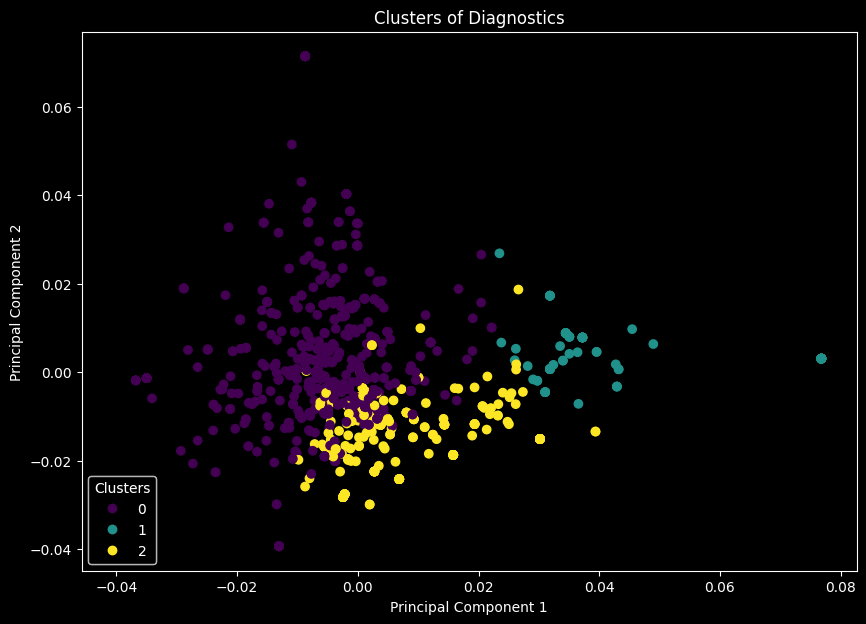

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()


## 6.2.PCA Max

In [ ]:
# Reducir la dimensionalidad de los vectores a 2 dimensiones con PCA:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_vec_2d = pca.fit_transform(data_vec_max)

In [ ]:
import pandas as pd

df_pca_max = pd.DataFrame(data_vec_2d, columns=['x', 'y'])
df_pca_max['cluster'] = labels_max

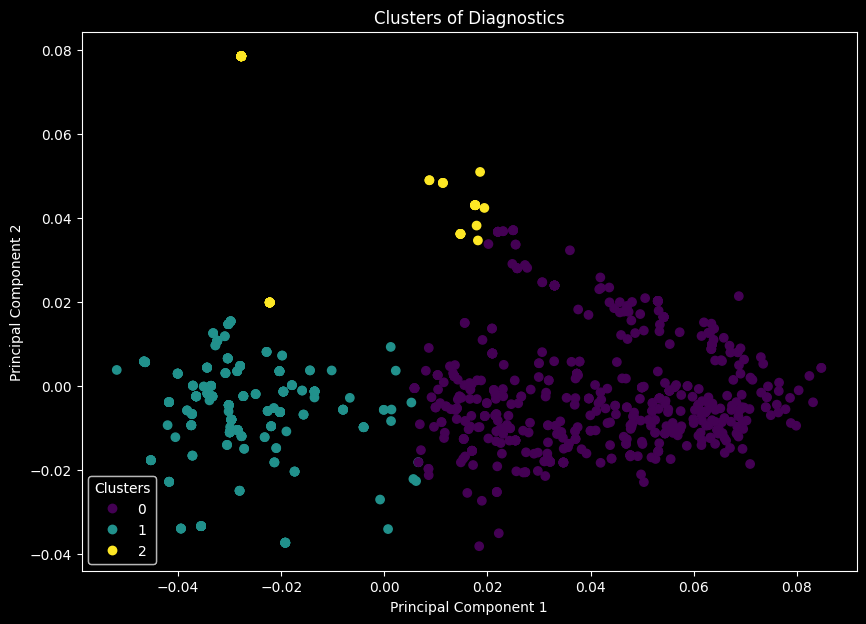

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca_max['x'], df_pca_max['y'], c=df_pca_max['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()

## 6.3.PCA Sum

In [ ]:
# Reducir la dimensionalidad de los vectores a 2 dimensiones con PCA:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_vec_2d = pca.fit_transform(data_vec_sum)

In [ ]:
import pandas as pd

df_pca_sum = pd.DataFrame(data_vec_2d, columns=['x', 'y'])
df_pca_sum['cluster'] = labels_sum

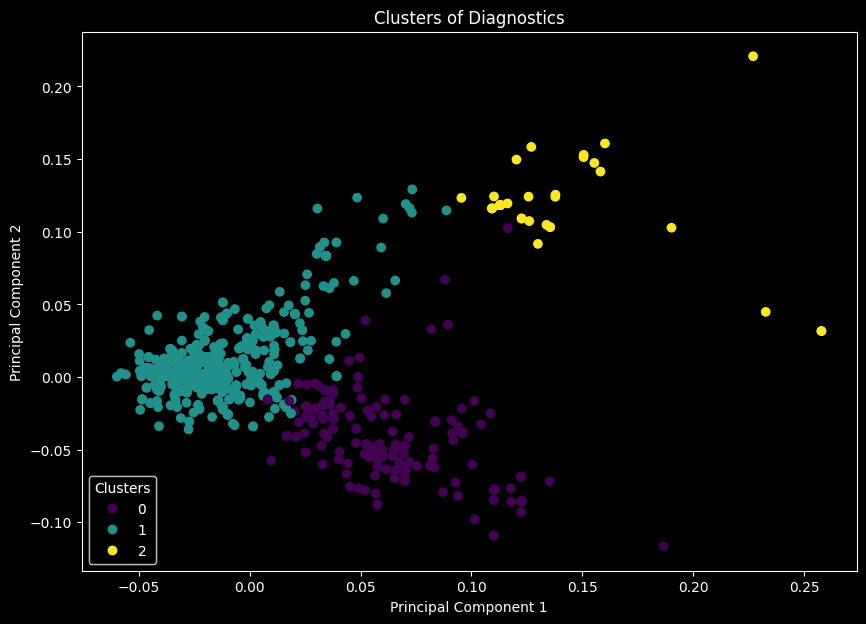

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_pca_sum['x'], df_pca_sum['y'], c=df_pca_sum['cluster'], cmap='viridis')
ax.set_title('Clusters of Diagnostics')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# create legend as per color map
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend1)

plt.show()

In [ ]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

trace = go.Scatter(
    x = df_pca_sum['x'],
    y = df_pca_sum['y'],
    mode = 'markers',
    marker=dict(
        size=6,
        color = df_pca_sum['cluster'], # set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

data = [trace]

fig = go.Figure(data=data)

iplot(fig)


# Estrategia
Una estrategia que podrías considerar es usar una combinación de estas métricas para obtener una visión más completa de tus datos. Por ejemplo, podrías usar la métrica mean para identificar las palabras que son más representativas de cada cluster en promedio, y luego usar la métrica max para identificar los temas o categorías que son más comunes en tus datos. Luego, podrías usar la métrica sum para obtener una visión general de qué palabras son más prevalentes en tus datos.

# 7.Análisis de grupos: 

Podría realizarse un análisis más profundo de cada grupo. Por ejemplo, examinar las características de los pacientes dentro de cada grupo para ver si hay alguna característica que distinga a los pacientes en un grupo de los pacientes en otro grupo.

In [ ]:
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   h_procedencia         4013 non-null   object
 1   s_procedencia         4013 non-null   object
 2   ap                    4013 non-null   object
 3   otros                 4013 non-null   object
 4   diagnostico           4013 non-null   object
 5   motivo_ing            4013 non-null   object
 6   paliativo_onc_noc     4013 non-null   object
 7   paliativo_no_onc_noc  4013 non-null   object
 8   fiebre                4013 non-null   object
 9   disnea                4013 non-null   object
 10  dolor                 4013 non-null   object
 11  delirium              4013 non-null   object
 12  otros_1               4013 non-null   object
 13  p_terminal            4013 non-null   object
 14  agonia                4013 non-null   object
 15  ps_ecog               4012 non-null   

In [ ]:
# Creamos un DataFrame con las palabras del diagnóstico y su etiqueta de grupo correspondiente
df_clusters = pd.DataFrame({'diagnostico': [' '.join(words) for words in diagnosticos_split], 'cluster': labels})

# Unimos este nuevo DataFrame con el DataFrame original
df_new = df_copy.join(df_clusters.set_index('diagnostico'), on='diagnostico')


In [ ]:
df_clusters.head()

diagnostico  cluster
0                cancer orl        2
1           melanoma vulvar        1
2       cancer broncogenico        2
3         cirrosis hepatica        1
4  neplasia mama estadio IV        0

In [ ]:
df_new.head()

h_procedencia s_procedencia  ap otros               diagnostico  \
0   gil casares          upal  no    no                cancer orl   
1       clinico     oncologia  no    no           melanoma vulvar   
2       clinico           mir  no    no       cancer broncogenico   
3       clinico     digestivo  no    no         cirrosis hepatica   
4       clinico     urgencias  no    no  neplasia mama estadio IV   

                   motivo_ing paliativo_onc_noc paliativo_no_onc_noc fiebre  \
0          control desintomas                si                   si     no   
1           mal control dolor                si                   no     no   
2           control evolutivo                si                   si     no   
3  admininistacion octreotido                no                   no     no   
4            control sintomas                si                   no     no   

  disnea dolor delirium otros_1 p_terminal agonia ps_ecog barthel gds_fast  \
0     no    si       no      no         si     no      40     300       no   
1     no    si       no      no         si     no      34      no       no   
2     si    no       no      no         no     no      34     400       no   
3     no    no       no      no         no     no      10     900       no   
4     si    si       no      no         si     no      40     300       no   

  eva_ing otros_2     otros_complicaciones  n_estancias  n_visitas sedacion  \
0      no      no   reingreso en urgencias           21         10       no   
1      no      no  met pulmonares y digest           24          8       no   
2      no      no                       no           14          6       no   
3      no      no                       no            1          1       no   
4      70      no                       no            2          1       no   

    motivo_alta        medico  year ast_anorx agudo_estable cronico_reag  \
0     reingreso        valdes  2017        si         vacio        vacio   
1        exitus   galego feal  2017        si         vacio        vacio   
2  fin cuidados  lopez renedo  2017        no         vacio        vacio   
3  fin cuidados  lopez renedo  2017        no         vacio        vacio   
4        exitus  lopez renedo  2017        no         vacio        vacio   

  trato_antibiotico transfusion paracentesis toracocentesis ayuntamiento  \
0             vacio       vacio        vacio          vacio  desconocido   
1             vacio       vacio        vacio          vacio  desconocido   
2             vacio       vacio        vacio          vacio  desconocido   
3             vacio       vacio        vacio          vacio  desconocido   
4             vacio       vacio        vacio          vacio  desconocido   

  fecha_alta  fe_iv  cluster  
0    unknown  vacio      2.0  
1    unknown  vacio      1.0  
2    unknown  vacio      2.0  
3    unknown  vacio      1.0  
4    unknown  vacio      0.0

In [ ]:
# Tamaño de los grupos
df_new['cluster'].value_counts()


1.0    2904
2.0     560
0.0     548
Name: cluster, dtype: int64

In [ ]:
# Análisis de las características de los pacientes dentro de cada grupo
df_new.groupby('cluster').describe()

n_estancias                                                      \
              count       mean        std  min  25%   50%    75%    max   
cluster                                                                   
0.0           548.0  16.270073  20.644197  0.0  4.0  10.0  20.25  204.0   
1.0          2904.0  14.362259  19.192652  0.0  4.0   8.0  16.00  304.0   
2.0           560.0  17.003571  19.565129  0.0  5.0  10.0  22.00  126.0   

        n_visitas                                                  year  \
            count      mean       std  min  25%  50%  75%   max   count   
cluster                                                                   
0.0         548.0  6.257299  6.576608  0.0  2.0  4.0  8.0  51.0   548.0   
1.0        2904.0  5.642562  6.666066  0.0  2.0  4.0  7.0  99.0  2904.0   
2.0         560.0  7.717857  8.406427  0.0  3.0  5.0  9.0  71.0   560.0   

                                                                        
                mean       std     min     25%     50%     75%     max  
cluster                                                                 
0.0      2019.737226  1.780537  2017.0  2018.0  2020.0  2021.0  2022.0  
1.0      2020.035813  1.771504  2017.0  2018.0  2020.0  2022.0  2022.0  
2.0      2019.382143  1.763383  2017.0  2018.0  2019.0  2021.0  2022.0

<Axes: xlabel='cluster', ylabel='year'>

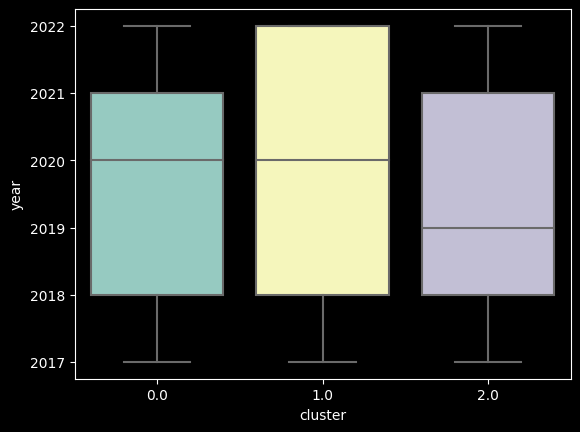

In [ ]:
# Visualización de las características de los pacientes dentro de cada grupo

import seaborn as sns

sns.boxplot(x='cluster', y='year', data=df_new)


<Axes: xlabel='cluster', ylabel='n_visitas'>

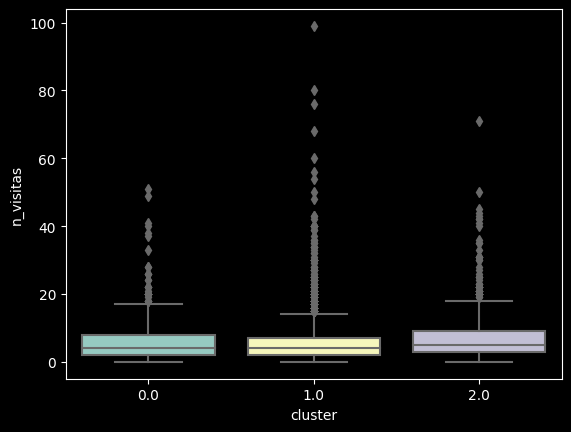

In [ ]:
sns.boxplot(x='cluster', y='n_visitas', data=df_new)

<Axes: xlabel='cluster', ylabel='n_estancias'>

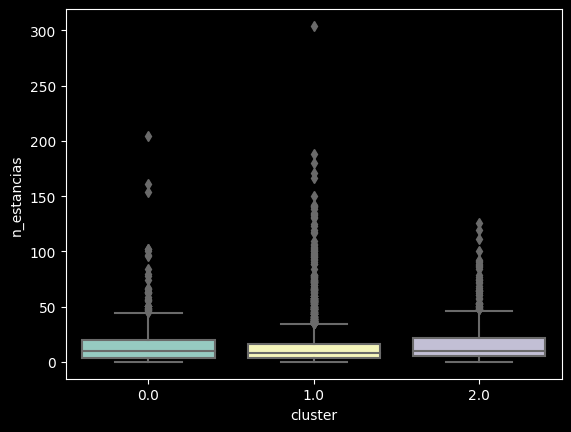

In [ ]:
sns.boxplot(x='cluster', y='n_estancias', data=df_new)

## 7.1.Análisis de la procedencia

In [ ]:
print(df_new.groupby('cluster')['h_procedencia'].value_counts())

cluster  h_procedencia       
0.0      clinico                  316
         no                       168
         conxo                     41
         gil casares               20
         provincial                 1
         quiron la coruna           1
         si                         1
1.0      clinico                 1574
         no                       934
         conxo                    256
         gil casares              111
         provincial                11
         chuac                      6
         residencia                 3
         rosaleda                   2
         si                         2
         ap                         1
         hula                       1
         lucus augusti              1
         pontevedra                 1
         salnes                     1
2.0      clinico                  350
         no                       148
         conxo                     32
         gil casares               26
         residencia 

In [ ]:
print(df_new.groupby('cluster')['s_procedencia'].value_counts())

cluster  s_procedencia        
0.0      oncologia                181
         no                       164
         upal                      47
         urgencias                 30
         mir                       24
                                 ... 
2.0      umap                       1
         umapmir                    1
         ume                        1
         urgencias hematologia      1
         urgencias oncologia        1
Name: s_procedencia, Length: 157, dtype: int64


## 7.2.Análisis del motivo de ingreso por cluster

In [ ]:
print(df_new.groupby('cluster')['motivo_ing'].value_counts())

cluster  motivo_ing                    
0.0      control sintomas                  308
         cuidados paliativos                30
         recambio peg                       20
         valoracion                         11
         antibioterapia IV                   8
                                          ... 
2.0      ulceras presion                     1
         valoracion ajuste tratamiento       1
         valoracion peg                      1
         valoracion tumoracion cervical      1
         vigilancia postoperatorio           1
Name: motivo_ing, Length: 654, dtype: int64


## 7.3.Análisis de la duración de la estancia (n_estancias) por cluster

In [ ]:
print(df_new.groupby('cluster')['n_estancias'].describe())

          count       mean        std  min  25%   50%    75%    max
cluster                                                            
0.0       548.0  16.270073  20.644197  0.0  4.0  10.0  20.25  204.0
1.0      2904.0  14.362259  19.192652  0.0  4.0   8.0  16.00  304.0
2.0       560.0  17.003571  19.565129  0.0  5.0  10.0  22.00  126.0


## 7.4.Análisis del médico asignado (medico) por cluster

In [ ]:
print(df_new.groupby('cluster')['medico'].value_counts())

cluster  medico             
0.0      fernandez benito       136
         galego feal            111
         lopez renedo            89
         suarez                  52
         villar del castillo     50
         valcarcel               27
         valdes                  26
         beceiro                 19
         masa                    17
         novo                    11
         gomez buela              6
         ibanez alonso            4
1.0      fernandez benito       635
         villar del castillo    473
         suarez                 406
         galego feal            385
         lopez renedo           358
         novo                   152
         gomez buela            133
         valdes                 133
         valcarcel               66
         ibanez alonso           59
         masa                    56
         beceiro                 47
         desconocido              1
2.0      villar del castillo    204
         suarez                 101

# 8.Análisis de frecuencia 

## 8.1.Por palabra clave en los diagnósticos

In [ ]:
print(len(diagnosticos_split), diagnosticos_split)

1459 [['cancer', 'orl'], ['melanoma', 'vulvar'], ['cancer', 'broncogenico'], ['cirrosis', 'hepatica'], ['neplasia', 'mama', 'estadio', 'IV'], ['anemia'], ['adenoca', 'pulmon'], ['leucemia', 'linfatica', 'cronica'], ['fx', 'meseta', 'tibial'], ['cancer', 'mama'], ['cancer', 'prostata'], ['deterioro', 'general'], ['tumor', 'cerebral'], ['adenoca', 'colon', 'IV'], ['cancer', 'colon'], ['neumonia'], ['niemannpick'], ['sarcoidosis'], ['cancer', 'pancreas'], ['infeccion', 'urinaria', 'fallo', 'cardiaco'], ['melanoma', 'fosa', 'nasal'], ['cancer', 'timo'], ['infeccion', 'respiratoria'], ['sdown'], ['bocio', 'intratoracico'], ['sepsisi', 'respiratoria'], ['intolerancia', 'oral'], ['infeccion', 'urinaria'], ['esclerosis', 'multiple'], ['demencia', 'fallo', 'multiorganico'], ['cancer', 'parotida'], ['ITU', '(infeccion', 'tracto', 'urinario)'], ['ulceras', 'mmii'], ['smd'], ['cancer', 'colon', 'estadio', 'IV'], ['fractura', 'cadera'], ['fallo', 'cardiaco'], ['cancer', 'endometrio'], ['cancer', 's

In [ ]:
from collections import Counter

# Concatena todas las listas de palabras en una sola lista
all_words = [word for sublist in diagnosticos_split for word in sublist]

# Cuenta la frecuencia de cada palabra
word_freq = Counter(all_words)

# Muestra las 10 palabras más comunes
most_common_words = word_freq.most_common(30)
most_common_words

[('cancer', 196),
 ('IV', 147),
 ('estadio', 138),
 ('infeccion', 103),
 ('insuficiencia', 72),
 ('neoplasia', 63),
 ('cardiaca', 52),
 ('cronica', 50),
 ('colon', 46),
 ('respiratoria', 45),
 ('tracto', 43),
 ('pulmon', 42),
 ('(infeccion', 42),
 ('urinario)', 42),
 ('ITU', 41),
 ('cognitivo', 41),
 ('ulcera', 38),
 ('deterioro', 36),
 ('demencia', 35),
 ('ulceras', 34),
 ('fragil', 28),
 ('carcinoma', 27),
 ('adenocarcinoma', 27),
 ('renal', 26),
 ('recto', 25),
 ('aguda', 24),
 ('prostata', 23),
 ('urinaria', 23),
 ('epidermoide', 23),
 ('epoc', 22)]

## 8.2.Análisis de n-gramas

In [ ]:
from nltk.util import ngrams

# Genera bigramas
bigrams = list(ngrams(all_words, 2))

# Cuenta la frecuencia de cada bigrama
bigram_freq = Counter(bigrams)

# Muestra los 10 bigramas más comunes
most_common_bigrams = bigram_freq.most_common(30)
most_common_bigrams


[(('estadio', 'IV'), 122),
 (('insuficiencia', 'cardiaca'), 51),
 (('(infeccion', 'tracto'), 42),
 (('tracto', 'urinario)'), 42),
 (('ITU', '(infeccion'), 41),
 (('infeccion', 'respiratoria'), 30),
 (('deterioro', 'cognitivo'), 27),
 (('cardiaca', 'cronica'), 27),
 (('IV', 'cancer'), 24),
 (('cancer', 'colon'), 17),
 (('cancer', 'epidermoide'), 17),
 (('pulmon', 'estadio'), 16),
 (('cognitivo', 'severo'), 16),
 (('infeccion', 'urinaria'), 15),
 (('colon', 'estadio'), 15),
 (('anciana', 'fragil'), 12),
 (('anciano', 'fragil'), 11),
 (('cancer', 'prostata'), 10),
 (('cancer', 'pulmon'), 10),
 (('demencia', 'avanzada'), 10),
 (('cancer', 'recto'), 9),
 (('prostata', 'estadio'), 9),
 (('neoplasia', 'colon'), 9),
 (('grado', 'IV'), 9),
 (('insuficiencia', 'renal'), 9),
 (('cirrosis', 'hepatica'), 8),
 (('mama', 'estadio'), 8),
 (('cancer', 'gastrico'), 8),
 (('IV', 'neoplasia'), 7),
 (('recto', 'estadio'), 7)]

In [ ]:
from nltk.util import ngrams

# Genera bigramas
trigrams = list(ngrams(all_words, 3))

# Cuenta la frecuencia de cada bigrama
trigram_freq = Counter(trigrams)

# Muestra los 10 bigramas más comunes
most_common_trigrams = trigram_freq.most_common(30)
most_common_trigrams

[(('(infeccion', 'tracto', 'urinario)'), 42),
 (('ITU', '(infeccion', 'tracto'), 41),
 (('insuficiencia', 'cardiaca', 'cronica'), 27),
 (('estadio', 'IV', 'cancer'), 20),
 (('pulmon', 'estadio', 'IV'), 15),
 (('colon', 'estadio', 'IV'), 13),
 (('deterioro', 'cognitivo', 'severo'), 11),
 (('prostata', 'estadio', 'IV'), 9),
 (('mama', 'estadio', 'IV'), 7),
 (('cancer', 'colon', 'estadio'), 7),
 (('estadio', 'IV', 'neoplasia'), 7),
 (('recto', 'estadio', 'IV'), 7),
 (('estadio', 'IV', 'infeccion'), 7),
 (('pancreas', 'estadio', 'IV'), 6),
 (('estadio', 'IV', 'adenocarcinoma'), 4),
 (('estadio', 'IV', 'demencia'), 4),
 (('insuficiencia', 'cardiaca', 'infeccion'), 4),
 (('obliteracion', 'femoro', 'poplitea'), 4),
 (('infeccion', 'respiratoria', 'insuficiencia'), 4),
 (('respiratoria', 'insuficiencia', 'cardiaca'), 4),
 (('infeccion', 'herida', 'quirurgica'), 3),
 (('estadio', 'IV', 'neo'), 3),
 (('ovario', 'estadio', 'IV'), 3),
 (('gastrico', 'estadio', 'IV'), 3),
 (('renal', 'estadio', 'IV

Estos análisis nos permiten ver cuáles son los diagnósticos más comunes entre los pacientes

# 9.Análisis de tendencias a lo largo del tiempo

## 9.1.Agrupación por año y diagnóstico

In [ ]:
diagnostic_counts = df_new.groupby(['year', 'diagnostico']).size()
print(diagnostic_counts.info(), diagnostic_counts.sort_values(ascending=False))

<class 'pandas.core.series.Series'>
MultiIndex: 1949 entries, (2017, 'ITU (infeccion tracto urinario)') to (2022, 'vmi insuficiencia respiratoria')
Series name: None
Non-Null Count  Dtype
--------------  -----
1949 non-null   int64
dtypes: int64(1)
memory usage: 32.5+ KB
None year  diagnostico                                        
2022  ITU (infeccion tracto urinario)                        67
      infeccion respiratoria                                 50
      insuficiencia cardiaca cronica                         47
      infeccion urinaria                                     43
2020  ITU (infeccion tracto urinario)                        40
                                                             ..
2019  sind hallerman sterif                                   1
      shock septico                                           1
      sepsis urinaria                                         1
      sde confusional leve insuficiencia cardiaca cronica     1
2022  vmi insuficiencia r

## 9.2.Visualización de las tendencias

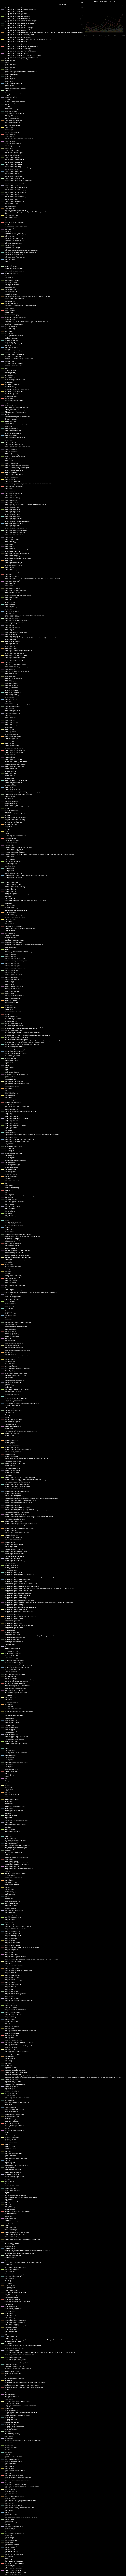

In [ ]:
diagnostic_counts.unstack('diagnostico').plot(kind='line')
plt.ylabel('Count')
plt.title('Trends in Diagnoses Over Time')
plt.show();

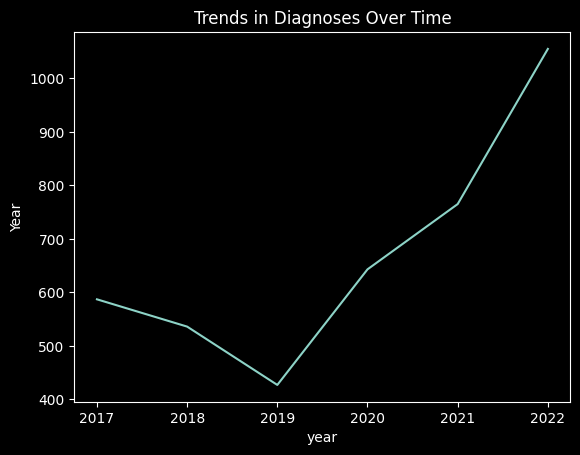

In [ ]:
year_counts = df_new.groupby('year').size()
year_counts.plot(kind='line')
plt.ylabel('Count')
plt.ylabel('Year')
plt.title('Trends in Diagnoses Over Time')
plt.show()

Al tener muchos diagnósticos distintos clasificaremos por los grupos de palabras más frecuentes en los diagnósticos

## 9.3.Top palabras mas comunes y bigramas

In [ ]:
# lista de palabras o bigramas a seguir
common_words = ['cancer', 'ulcera', 'respiratorio', 'infeccion', 'insuficiencia']  
common_bigrams = [('estadio', 'IV'), ('insuficiencia', 'cardiaca'), ('(infeccion', 'tracto')]


In [ ]:
#  nueva columna para las palabras o bigramas comunes

def match_word(x, words):
    for word in words:
        if word in x:
            return word
    return None

def match_bigram(x, bigrams):
    words = x.split()
    for i in range(len(words) - 1):
        if (words[i], words[i+1]) in bigrams:
            return (words[i], words[i+1])
    return None

df_new['common_word'] = df_new['diagnostico'].apply(lambda x: match_word(x, common_words))
df_new['common_bigram'] = df_new['diagnostico'].apply(lambda x: match_bigram(x, common_bigrams))


In [ ]:
pd.get_dummies(df_new, columns=['common_word', 'common_bigram'])

h_procedencia s_procedencia  ap otros                      diagnostico  \
0      gil casares          upal  no    no                       cancer orl   
1          clinico     oncologia  no    no                  melanoma vulvar   
2          clinico           mir  no    no              cancer broncogenico   
3          clinico     digestivo  no    no                cirrosis hepatica   
4          clinico     urgencias  no    no         neplasia mama estadio IV   
...            ...           ...  ..   ...                              ...   
4008       clinico     oncologia  no    no           cancer mama estadio IV   
4009       clinico           mir  no    no                   anciano fragil   
4010       clinico           mir  no    no              oclusion intestinal   
4011       clinico     urgencias  no    no  ITU (infeccion tracto urinario)   
4012       clinico     oncologia  no    no                     glioblastoma   

                         motivo_ing paliativo_onc_noc paliativo_no_onc_noc  \
0                control desintomas                si                   si   
1                 mal control dolor                si                   no   
2                 control evolutivo                si                   si   
3        admininistacion octreotido                no                   no   
4                  control sintomas                si                   no   
...                             ...               ...                  ...   
4008               control sintomas                si                   no   
4009                    seguimiento                no                   si   
4010  cuidados paliativos avanzados                si                   si   
4011              antibioterapia IV                no                   si   
4012               control sintomas                si                   no   

     fiebre disnea dolor delirium otros_1 p_terminal agonia ps_ecog barthel  \
0        no     no    si       no      no         si     no      40     300   
1        no     no    si       no      no         si     no      34      no   
2        no     si    no       no      no         no     no      34     400   
3        no     no    no       no      no         no     no      10     900   
4        no     si    si       no      no         si     no      40     300   
...     ...    ...   ...      ...     ...        ...    ...     ...     ...   
4008     no     no    si       no      no      vacio  vacio      34      40   
4009     no     si    no       no      no      vacio  vacio      no      30   
4010     no     si    si       no      no      vacio  vacio      40      20   
4011     si     no    no       si      no      vacio  vacio      no      20   
4012     no     no    si       si      no      vacio  vacio      40      00   

     gds_fast eva_ing      otros_2     otros_complicaciones  n_estancias  \
0          no      no           no   reingreso en urgencias           21   
1          no      no           no  met pulmonares y digest           24   
2          no      no           no                       no           14   
3          no      no           no                       no            1   
4          no      70           no                       no            2   
...       ...     ...          ...                      ...          ...   
4008       no     NaN  desconocido                       no           15   
4009       40     NaN  desconocido                       no            6   
4010       no     NaN  desconocido                       no           21   
4011       7c     NaN  desconocido                       no           11   
4012       no     NaN  desconocido                       no           11   

      n_visitas sedacion     motivo_alta               medico  year ast_anorx  \
0            10       no       reingreso               valdes  2017        si   
1             8       no          exitus          galego feal  2017        si   
2             

## 9.4.One-hot encoding de las nuevas columnas

In [ ]:
# One-hot encoding de las nuevas columnas

df_new = pd.get_dummies(df_new, columns=['common_word', 'common_bigram'])


In [ ]:
# Agrupo por año y sumo las columnas
word_counts = df_new.filter(regex='common_word').groupby(df_new['year']).sum()
bigram_counts = df_new.filter(regex='common_bigram').groupby(df_new['year']).sum()
print(word_counts)
print(bigram_counts)

      common_word_cancer  common_word_infeccion  common_word_insuficiencia  \
year                                                                         
2017                 145                     76                         17   
2018                 140                     57                         24   
2019                 115                     49                         18   
2020                 127                    109                         43   
2021                 142                     98                         43   
2022                 137                    208                         74   

      common_word_respiratorio  common_word_ulcera  
year                                                
2017                         0                  19  
2018                         1                   7  
2019                         0                  12  
2020                         0                  27  
2021                         0                  35  
2022

## 9.5.Visualización de las tendencias

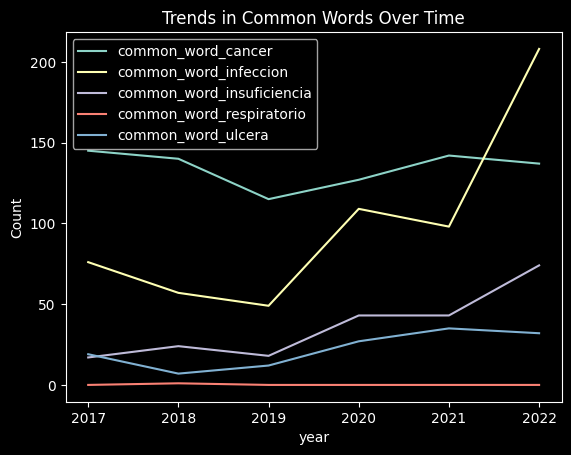

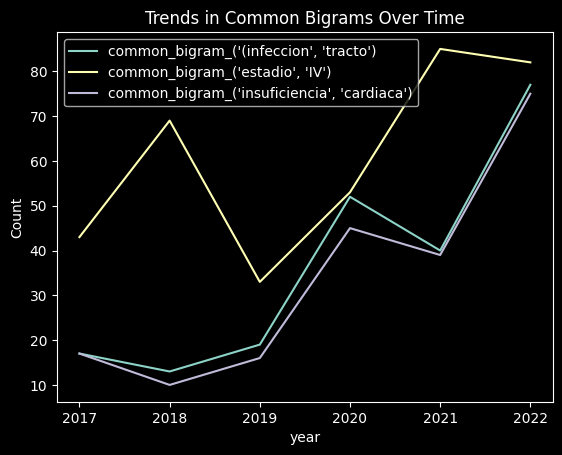

In [ ]:
word_counts.plot(kind='line')
plt.ylabel('Count')
plt.title('Trends in Common Words Over Time')
plt.show()

bigram_counts.plot(kind='line')
plt.ylabel('Count')
plt.title('Trends in Common Bigrams Over Time')
plt.show()


# Otros...

* Análisis de grupos: Podrías realizar un análisis más profundo de cada grupo. Por ejemplo, podrías examinar las características de los pacientes dentro de cada grupo para ver si hay alguna característica que distinga a los pacientes en un grupo de los pacientes en otro grupo.

* Análisis de tendencias a lo largo del tiempo: Si tienes datos de tiempo, podrías examinar cómo han cambiado los diagnósticos a lo largo del tiempo. ¿Han aumentado o disminuido ciertos diagnósticos? ¿Ha habido cambios en los grupos de diagnósticos a lo largo del tiempo?

* Predecir diagnósticos: Si tienes un objetivo específico, como predecir un cierto diagnóstico basándote en las características de un paciente, podrías entrenar un modelo de aprendizaje automático supervisado utilizando tus vectores de diagnósticos como entrada.

* Análisis de sentimiento: Si tus diagnósticos incluyen texto escrito por médicos o pacientes, podrías considerar realizar un análisis de sentimiento para entender mejor cómo se sienten los pacientes o cómo perciben su condición.

* Pruebas de correlación: Podrías realizar pruebas de correlación entre diferentes variables para ver si hay alguna relación entre, por ejemplo, la edad de un paciente y el tipo de diagnóstico que recibe.

Preprocesamiento de los datos:
    
    Codificación de Frecuencias: En este método, reemplazas cada categoría de la variable por la frecuencia con la que aparece en el conjunto de datos. Por ejemplo, si la categoría 'resfriado común' aparece 100 veces en la variable 'diagnóstico', entonces reemplazas 'resfriado común' por 100. Aquí te dejo un ejemplo de cómo hacerlo con pandas:

In [15]:
df_freq = df.copy()
df_freq.head()

h_procedencia s_procedencia  ap otros                  diagnostico  \
0   gil casares          upal  no    no                   cancer orl   
1       clinico     oncologia  no    no              melanoma vulvar   
2       clinico           mir  no    no          cancer broncogenico   
3       clinico     digestivo  no    no            cirrosis hepatica   
4       clinico     urgencias  no    no  neplasia de mama estadio IV   

                  motivo_ing paliativo_onc_noc paliativo_no_onc_noc fiebre  \
0           control sintomas                si                   si     no   
1          mal control dolor                si                   no     no   
2          control evolutivo                si                   si     no   
3  administracion octreotido                no                   no     no   
4           control sintomas                si                   no     no   

  disnea dolor delirium otros_1 p_terminal agonia ps_ecog barthel gds_fast  \
0     no    si       no      no         si     no      40     300       no   
1     no    si       no      no         si     no      34      no       no   
2     si    no       no      no         no     no      34     400       no   
3     no    no       no      no         no     no      10     900       no   
4     si    si       no      no         si     no      40     300       no   

  eva_ing otros_2     otros_complicaciones  n_estancias  n_visitas sedacion  \
0      no      no   reingreso en urgencias           21         10       no   
1      no      no  met pulmonares y digest           24          8       no   
2      no      no                       no           14          6       no   
3      no      no                       no            1          1       no   
4      70      no                       no            2          1       no   

       motivo_alta        medico       year ast_anorx agudo_estable  \
0        reingreso        valdes 2017-01-01        si         vacio   
1           exitus   galego feal 2017-01-01        si         vacio   
2  fin de cuidados  lopez renedo 2017-01-01        no         vacio   
3  fin de cuidados  lopez renedo 2017-01-01        no         vacio   
4           exitus  lopez renedo 2017-01-01        no         vacio   

  cronico_reag trato_antibiotico transfusion paracentesis toracocentesis  \
0        vacio             vacio       vacio        vacio          vacio   
1        vacio             vacio       vacio        vacio          vacio   
2        vacio             vacio       vacio        vacio          vacio   
3        vacio             vacio       vacio        vacio          vacio   
4        vacio             vacio       vacio        vacio          vacio   

  ayuntamiento fecha_alta  fe_iv  
0  desconocido    unknown  vacio  
1  desconocido    unknown  vacio  
2  desconocido    unknown  vacio  
3  desconocido    unknown  vacio  
4  desconocido    unknown  vacio

In [16]:
# Creas un mapeo de frecuencias
freq_map = df_freq['diagnostico'].value_counts().to_dict()

# Aplicas el mapeo a la columna 'diagnostico'
df_freq['diagnostico'] = df_freq['diagnostico'].map(freq_map)


In [22]:
print(len(df_freq['diagnostico'].unique()), 
      "\n\n",
      df_freq['diagnostico'].unique())

40 

 [  7   1   4  57  28   2  21   5  12  23  54   6  30 145 112  15 172   3
  11  13   8  16  24  44  17  73  34  27  58   9  70  39  10  18  26  33
  42  22  14  69]


Codificación de Target

In [ ]:
import category_encoders as ce

# Asegúrate de dividir tus datos en conjuntos de entrenamiento y prueba primero
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica la codificación al conjunto de entrenamiento
target_enc = ce.TargetEncoder(cols=['diagnostico']).fit(X_train, y_train)

# Transforma tus conjuntos de datos
X_train = target_enc.transform(X_train)
X_test = target_enc.transform(X_test)

Paso 2: Selección de Características

Una vez que hayas convertido estas variables a formatos numéricos, puedes utilizar todas las demás variables como características para predecir la variable 'diagnostico'. También puedes realizar una selección de características para determinar cuáles son las más importantes para tu modelo.

* **Eliminación Recursiva de Características (RFE)**: RFE es una técnica que elimina las características una por una, basándose en la importancia de las características calculada por un modelo específico.
````python
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# define el método de selección de características
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

# ajusta y aplica la transformación
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

````
* **Importancia de la característica basada en el modelo**: Algunos modelos de Machine Learning ofrecen una forma de clasificar las características por importancia.
````python
from sklearn.ensemble import RandomForestClassifier

# define el modelo
model = RandomForestClassifier()

# entrena el modelo
model.fit(X_train, y_train)

# obtén la importancia de las características
importance = model.feature_importances_

# resume la importancia de las características
for i,j in enumerate(importance):
    print('Característica: %0d, Puntuación: %.5f' % (i,j))
````

* **Correlación de Pearson**: La correlación de Pearson mide la dependencia lineal entre dos variables. Podemos usarla para seleccionar las características más correlacionadas con la variable objetivo.

````python
# calcula la correlación de Pearson de las características con la variable objetivo
correlations = df.corrwith(df['diagnostico']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()

# imprime las características más correlacionadas
top_features = correlations.sort_values('abs', ascending=False)[0]
print(top_features)
````


Paso 3: Creación y Entrenamiento del Modelo

Como mencioné anteriormente, puedes probar varios modelos como el árbol de decisión, bosque aleatorio, SVM, KNN y la regresión logística multiclase. Aquí te dejo un ejemplo de cómo hacerlo con un modelo de bosque aleatorio:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crea el modelo
model = RandomForestClassifier()

# Entrena el modelo
model.fit(X_train, y_train)

Paso 4: Evaluación del Modelo

Para evaluar tu modelo, puedes utilizar la precisión, recall, F1-score, ROC-AUC, etc. También puedes utilizar una matriz de confusión para ver cómo se comporta tu modelo en cada una de las clases:

In [ ]:
from sklearn.metrics import classification_report

# Haz predicciones en tu conjunto de prueba
y_pred = model.predict(X_test)

# Imprime el informe de clasificación
print(classification_report(y_test, y_pred))